### Import packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import math 
import xlwt
from tempfile import TemporaryFile
import random
from scipy.stats import ttest_ind

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Geometric Brownian Motion (GBM)

In general, GBM given by the equation $G_t = G_0e^{Xt}$, where $X_t = \sigma B_t + \mu t$is a Brownian motion with drift and $G_0$ is the initial value.


### Simulation of sample GBM sample paths
In this section, we simulate four different sample paths with the GBM equation. 

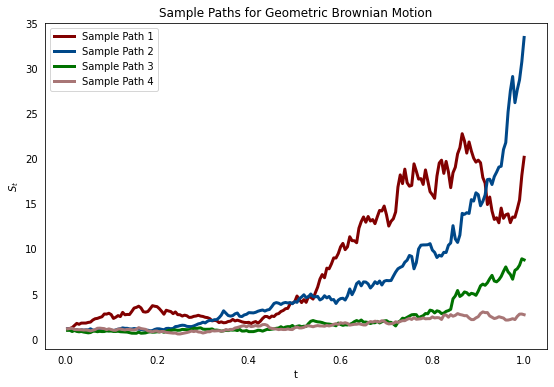

In [67]:
%matplotlib inline

# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
pal = ['#810000','#004889', '#007200',"#A87676"]

# SDE model parameters
mu, sigma, X0 = 2, 1, 1

# Simulation parameters
T, N = 1, 200
dt = 1.0 / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

# Title and Label 
plt.title('Sample Paths for Geometric Brownian Motion')
plt.ylabel('$S_t$'); plt.xlabel('t')

# Create and plot sample paths
for i in range(len(pal)):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Compute exact solution
    Y = X0 * np.exp(sigma*B + mu*t)
    
    # Add line to plot
    plt.plot(t, Y, label = "Sample Path " + str(i+1), color=pal[i])

# Add legend
plt.legend(loc = 2);

## Call Option Price 

We define the price of the call option to be $C_0=e^{-rT}max(S_t-K, 0)$ and we implement this definition as follows: 

In [3]:
def call_option_price(x, r, T, K):
    price = np.exp(-r*T)*max(x-K, 0)
    return price

In [4]:
def put_option_price(x, r, T, K):
    price = np.exp(-r*T)*max(K-x, 0)
    return price 

## Black Scholes Implementation 
The Black Scholes model is mathematical equation that estimates the theoretical value of derivatives while accounting for time and risk factors. It remains as one of the most important and widely used formulas in quantitative finance to calculate the price of European options. We have implemented the Black Scholes model for both call and put options as follows:

In [70]:
from scipy.stats import norm

N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S*N(d1) - K * np.exp(-r*T)* N(d2)
    return price 

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    price = K*np.exp(-r*T)*N(-d2) - S*N(-d1)
    return price

In [71]:
# Example 
BS_CALL(100, 100, 0.5, 0.01, 0.4)

11.46936323203694

## Binomial Options Pricing Model 

The Binomial Option Pricing Model (BOPM) is another options valuation method developed in 1979. It uses discrete time model that predicts either an upward or downward movement at each timestep given the volatility and time to expiration. This produces a binomial distribution of the price of the underlying assets and BOPM is a theoretical representation of all possible paths that the underlying asset can take during the contract period of the option. 

Reference: https://www.linkedin.com/pulse/option-pricing-black-scholes-v-binomial-monte-carlo-stringham/

### BOPM (European Options)

In [72]:
### Binomial Model for European Option 

# Reference: https://www.codearmo.com/python-tutorial/options-trading-binomial-pricing-model
def binom(n, k):
    return math.factorial(n) / (math.factorial(n-k)*math.factorial(k))

# S0 = stock price at time 0, K = strike price, T = duration, r = 1 + rf, sigma = size of change/volatility, N = no. of steps 
def bopm_european(S0, K, T, r, sigma, N, optiontype = "call"):
    
    # find size of time step, up/down multiplier, and prob of moving up after cont compounding
    dt = T/N 
    U = np.exp(sigma*np.sqrt(dt))
    D = np.exp(-sigma*np.sqrt(dt))  
    p = (np.exp(r*dt) - D)/(U - D)
    val = 0 
    
    # N = 4 steps, find the prob of each node and the ending St of each node 
    for k in range(N+1):
        prob = binom(N, k)*p**k*(1-p)**(N-k) 
        St = S0*U**k*D**(N-k)
        
        # find the expected option payoff by summing up all the prob*option price 
        if optiontype == "call":
            val += max(St - K, 0)*prob 
        elif optiontype == "put":
            val += max(K - St, 0)*prob 
    PV = val*np.exp(-r*T) # discount back to price today 
    return PV 

In [73]:
bopm_european(100, 105, 0.5, 0.05, 0.4, 4)

10.287301121702995

### BOPM (American options)

A stock tree can be represented using nodes (i, j) and initial stock price ($S_0$):
$$ S_{i, j} = S_0U^jd^{i-j}$$
$C_{i, j}$ represents contract price at each node $(i, j)$ and $C_{N, j}$ represents final payoff function. 

For American Put options, 
* if $T = t_N$, then at the terminal nodes, $C^j_N = (K - S^j_N)^+$. 
* for all other nodes of the tree $(i, j)$: $C_i^j = max((K - S^j_i)^+, exp^{-r\Delta t}\{p^j_iC^{j+1}_{i+1} + (1-p^j_i)C^{j-1}_{i-1}\})$

In [74]:
# Reference: https://www.youtube.com/watch?v=K2Iy8bCmXjk
def bopm_american(S0, K, T, r, sigma, N, optiontype = "call"):
    dt = T/N 
    U = np.exp(sigma*np.sqrt(dt))
    D = np.exp(-sigma*np.sqrt(dt)) 
    p = (np.exp(r*dt) - D)/(U - D)
    disc = np.exp(-r*dt)
    
    # initialize stock prices at maturity 
    S = np.zeros(N+1)
    for j in range(N+1):
        S[j] = S0*U**j * D**(N-j) # S is a array of values at each time step
        
    # option payoff: max(unexercised, exercised) 
    C = np.zeros(N+1) 
    for j in range(N+1):
        if optiontype == "put":
            C[j] = max(0, K - S[j]) # C is the payoff at each time step 
        else:
            C[j] = max(0, S[j] - K)

    # backward recursion through the tree 
    # for each possible path, find the price of asset and the payoff
    for i in np.arange(N-1, -1, -1): # [N-1 N-2 ... 0]
        for j in range(i+1): # for each column, we iterate thru the rows 
            S = S0*U**j * D**(i-j) # change the len col each time we go back in time 
            C[j] = disc*(p*C[j+1] + (1-p)*C[j]) # risk-neutral pricing appraoch
            if optiontype == "put":
                C[j] = max(C[j], K - S) # max(cont val, exercise val)
            else:
                C[j] = max(C[j], S - K)
                
    return C[0]

In [75]:
bopm_american(100, 105, 0.5, 0.05, 0.4, 4)

10.287301121702995

## Euler Scheme 
Euler scheme takes the form of $\hat{X}_{kh} =\hat{X}_{(k-1)h}+\mu((k-1)h, \hat{X}_{(k-1)h})h +\sigma((k-1)h, \hat{X}_{(k-1)h})\sqrt{h}Z_k$, where $Z_k$'s are IID random variables distributed by $N(0,1)$, $h$ is the size of each time step, and $k$ is the number of steps. 

### Effect on time step size on Euler Scheme Approximation 

In this section, we want to examine the effect of time step size on the accuracy of the approximation to the exact solution. We find that a smaller time step (hence more steps) will give a more accurate result.

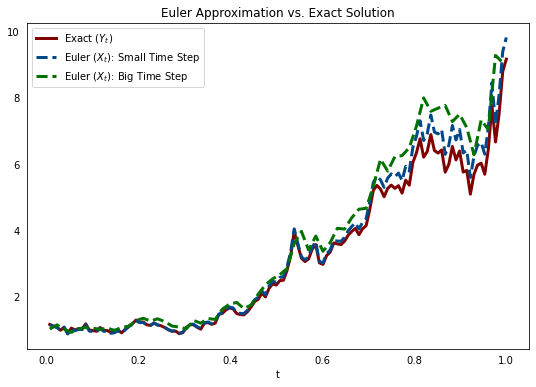

In [76]:
# SDE model parameters
mu = 2
sigma = 1
X0 = 1

# Simulation parameters
T = 1
n = 2**7
dt = 1.0 / n
t = np.arange(dt, 1 + dt, dt)

# Create Brownian Motion
np.random.seed(1)
dB = np.sqrt(dt) * np.random.randn(n)
B  = np.cumsum(dB)

# Exact Solution
Y = X0 * np.exp((mu - 0.5*sigma**2)*t + (sigma * B))
# Y = X0 * np.exp(sigma*B + mu*t)

# Euler Approximation with small time step
X_euler_small = []
X = X0
for j in range(n):  
    X += mu*X*dt + sigma*X*dB[j]
    X_euler_small.append(X)

# Euler Approximation with big time step
X_euler_big = []
X = X0
R = 2
coarse_grid = np.arange(dt, 1+dt, R*dt)
for j in range(int(n/R)):
    X += mu*X* (R*dt) + sigma*X*sum(dB[R*(j-1):R*j])
    X_euler_big.append(X)    
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)", color='#810000')
plt.plot(t, X_euler_small, label="Euler ($X_t$): Small Time Step", color = '#004889', ls='--')
plt.plot(coarse_grid, X_euler_big, label="Euler ($X_t$): Big Time Step", color= '#007200', ls='--')
plt.title('Euler Approximation vs. Exact Solution'); plt.xlabel('t'); plt.legend(loc = 2);

## Milstein Scheme 
Milstein Scheme takes the form of 
$\hat{X}_{kh} = \hat{X}_{(k-1)h}+\mu((k-1)h, \hat{X}_{(k-1)h})h +\sigma((k-1)h, \hat{X}_{(k-1)h})\sqrt{h}Z_k+\frac{1}{2}\sigma'( \hat{X}_{(k-1)h})\sigma'(\hat{X}_{(k-1)h})h(Z_k^2-1).$ It is believed that the additional term works as a "correction term" that improves the accuracy of the Euler scheme. Milstein scheme is believed to have a faster convergence as compared to the Euler Scheme. 

For brief comparison purpose, let us plot the approximation of Euler and Milstein against exact solutions. We can see that Milstein scheme gives a more accurate result. 

In [79]:
# Milstein Approximation
Xmil, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j] + 0.5*sigma**2 * X * (dB[j] ** 2 - dt)
    Xmil.append(X)
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)",color= '#810000')
plt.plot(t, Xmil, label="Milstein ($X_t$)",color= '#004889',ls='--')
plt.plot(t, X_euler_small, label="Euler ($X_t$)",color= '#007200',ls='--')
plt.title('Euler vs Milstein Approximation vs Exact Solution')
plt.xlabel('t'); plt.legend(loc=2);

TypeError: 'method' object cannot be interpreted as an integer

## Geometric Brownian Motion 

### Euler Scheme (European options) 
In this section, we create a generalized function that, given the inputs $x_0, r, T, K, h, n, \sigma, \alpha$, will give us the estimated price of an European option under the Euler scheme. The general idea is that we simulate n different sample paths and find the average price and variance and its corresponding confidence interval.

In [85]:
def euro_euler_gbm(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    f = []
    t = []
    
    # simulate n paths 
    for j in range(n):
        t = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*h + sigma*x*math.sqrt(h)*z # price of asset 
            price.append(x)
            t = t + h 
        
        if optiontype == "call":
            f += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(x, r, T, K)]
        
        # plotting price of asset against time 
        time = np.arange(0, T, h).tolist()
        plt.plot(time, price, linewidth = 0.5)
        plt.title(f'{n} Sample Paths of Underlying Asset Price by Euler Scheme'); plt.xlabel('t'); plt.ylabel("Price of Asset")
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    print(f"Expected Price = {theta[0]}")
    print(f"Variance = {variance[0]}")
    print(f"CI = {CI}")
    
    return theta, variance, CI

Expected Price = 11.76724500232937
Variance = 412.3263236845139
CI = (10, 13)


array([11.767245])

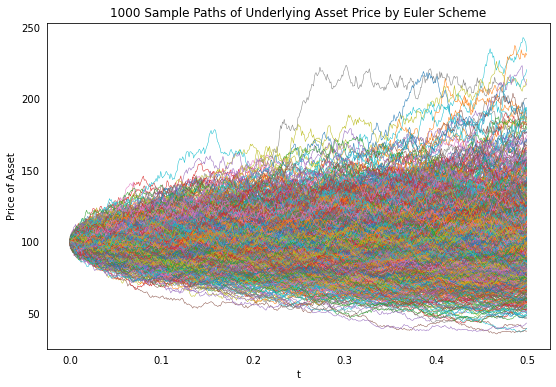

In [81]:
# Test example
euro_euler_gbm(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")[0]

BS = 10.970611151305178
BOPM = 10.967806591808007
Expected Price = 11.807580900201579
Variance = 197.8100685003949
CI = (10, 12)
Euler (GBM) = 11.807580900201579


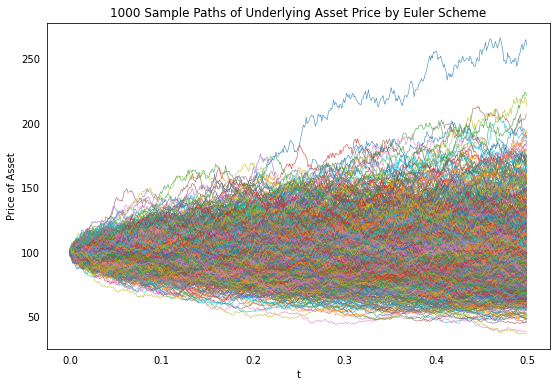

In [89]:
## Comparison against benchmark models 
print("BS =", BS_PUT(100, 100, 0.5, 0.01, 0.4))
print("BOPM =", bopm_european(100, 100, 0.5, 0.01, 0.4, 1000, optiontype = "put"))
print("Euler (GBM) =", euro_euler_gbm(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "put")[0][0])

### Milstein Scheme (European options)
In this section, we create a generalized function that, given the inputs $x_0, r, T, K, h, n, \sigma, \alpha$, will give us the estimated price of an European option under the Milstein scheme. The general idea is that we simulate n different sample paths and find the average price and variance and its corresponding confidence interval.

In [91]:
def euro_milstein_gbm(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):

    f = []
    
    for j in range(n):
        t = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*h + sigma*x*math.sqrt(h)*z + 0.5*sigma*sigma*x*h*(z**2 - 1)
            price.append(x)
            t = t + h 
          
        if optiontype == "call":
            f += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(x, r, T, K)]
        
        # plotting 
        time = np.arange(0, T, h).tolist()
        plt.plot(time, price, linewidth = 0.5)
        plt.title('1000 Sample Paths of Underlying Asset Price by Milstein Scheme'); plt.xlabel('t'); plt.ylabel("Price of Asset")
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    print(f"Expected Price = {theta}")
    print(f"Variance = {variance}")
    print(f"CI = {CI}")
    
    return theta, variance, CI

Expected Price = [11.27071933]
Variance = [382.64286138]
CI = (10, 12)


(array([11.27071933]), array([382.64286138]), (10, 12))

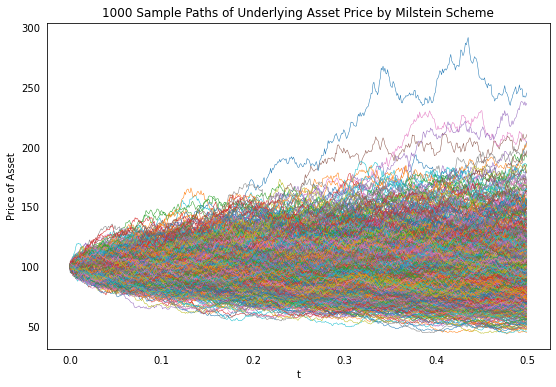

In [92]:
euro_milstein_gbm(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)

BS = 10.970611151305178
BOPM = 11.466558672541083


<ipython-input-54-fb3edb02740e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


Expected Price = [10.80925284]
Variance = [190.44364271]
CI = (9, 11)
Milstein (GBM) = 10.809252844959927


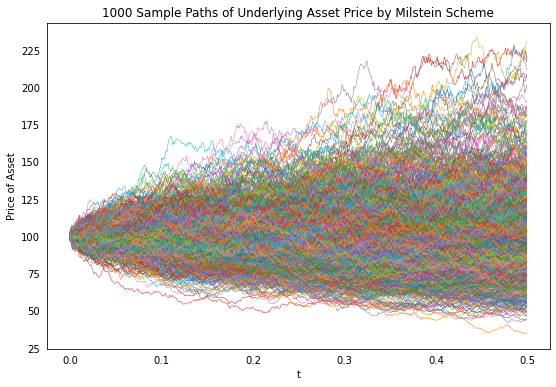

In [56]:
## Comparison against benchmark models 
print("BS =", BS_CALL(100, 100, 0.5, 0.01, 0.4))
print("BOPM =", bopm_european(100, 100, 0.5, 0.01, 0.4, 1000))
print("Milstein (GBM) =", euro_milstein_gbm(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "put")[0][0])

### Average Variance (Euler vs Milstein for European Options under GBM)

Theoretically, the the Milstien scheme is believed to have a lower average variance than the Euler scheme and we want to test out this hypothesis. To do so, we simulate Euler and Milstein scheme 1000 times each with the same randomness for easier comparison. For convenience purpose, we will save our results into excel for future use. In addition, we also used histogram plot to visualize our data.

In [15]:
# # Implementation of 1000 runs of Euler scheme
# np.random.seed(1)
# def euler1000(x0, r, T, K, h, n, sigma, alpha):
#     variance = []
#     for i in range(1000):
#         variance.append(int(euler_gbm(x0, r, T, K, h, n, sigma, alpha)[1]))
#     expected_variance = sum(variance)/1000
#     variance.append(expected_variance)
#     return variance

# eulerdata = euler1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)
# # print(eulerdata)

In [16]:
# # Save results to excel 
# book = xlwt.Workbook()
# sheet1 = book.add_sheet('sheet1')

# for i,e in enumerate(eulerdata):
#     sheet1.write(i,1,e)

# name = "euler_seed.xls"
# book.save(name)
# book.save(TemporaryFile())

In [17]:
# # Implementation of 1000 runs of Milstein scheme
# np.random.seed(1)
# def milstein1000(x0, r, T, K, h, n, sigma, alpha):
#     variance = []
#     for i in range(1000):
#         variance.append(int(milstein_gbm(x0, r, T, K, h, n, sigma, alpha)[1]))
#     expected_variance = sum(variance)/1000
#     variance.append(expected_variance)
#     return variance

# milsteindata = milstein1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)

In [18]:
# # Save results to excel 
# book = xlwt.Workbook()
# sheet2 = book.add_sheet('sheet2')

# for i,e in enumerate(milsteindata):
#     sheet2.write(i,1,e)

# name = "milstein_seed.xls"
# book.save(name)
# book.save(TemporaryFile())

In [27]:
# Converting our saved results to a list 

euler = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 1/euler_seed.xls")
eulerdata = euler["Variance Value"].to_list()

milstein = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 1/milstein_seed.xls")
milsteindata = milstein["Variance Value"].to_list()

Average Euler Variance (GBM)= 389.889
Average Milstein Variance (GBM)= 390.136


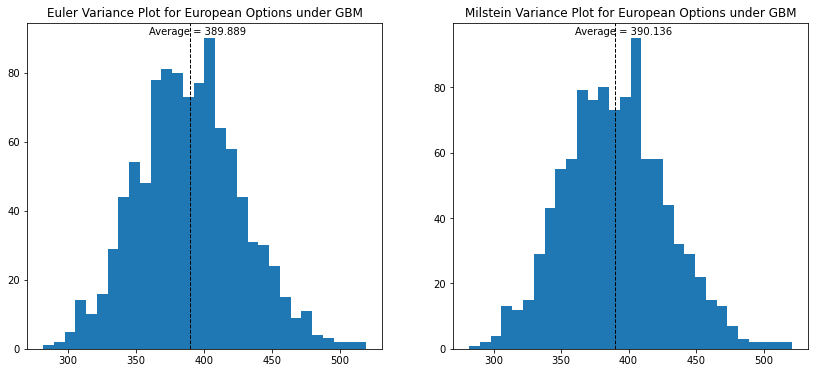

In [28]:
def average(l):
    return sum(l) / len(l)

fig = plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Euler Variance Plot for European Options under GBM")
plt.hist(eulerdata, bins = 30)
plt.axvline(eulerdata[-1], color='k', linestyle='dashed', linewidth=1)
plt.text(eulerdata[-1] - 30, 91, f'Average = {eulerdata[-1]}')

print("Average Euler Variance (GBM)=", eulerdata[-1])
print("Average Milstein Variance (GBM)=", milsteindata[-1])

plt.subplot(1, 2, 2)
plt.title("Milstein Variance Plot for European Options under GBM")
plt.hist(milsteindata, bins = 30)
plt.axvline(milsteindata[-1], color='k', linestyle='dashed', linewidth=1)
plt.text(milsteindata[-1] - 30, 96, f'Average = {milsteindata[-1]}')
plt.show()

### Hypothesis Testing 
We would like to conduct hypothesis testing with a significance level of 0.05 to see if there are significant difference between the average variance of Euler and Milstein scheme. More explicitly, our null hypothesis is that there is no significant difference between the variance of Euler and Milstein Scheme.

In [30]:
from scipy.stats import ttest_ind
import numpy as np

euler = eulerdata[:-1]
milstein = milsteindata[:-1]

euler_mean = np.mean(euler)
euler_std = np.std(euler)
print(f"Euler: mean = {euler_mean}, sd = {euler_std}")

milstein_mean = np.mean(milstein)
milstein_std = np.std(milstein)
print(f"Milstein: mean = {milstein_mean}, sd = {milstein_std}")

ttest,pval = ttest_ind(euler, milstein)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

Euler: mean = 389.889, sd = 38.32517030620999
Milstein: mean = 390.136, sd = 38.381447393239355
p-value 0.885567534177661
We fail to reject the null hypothesis.


### Euler Scheme (Asian Options)

In [62]:
def asian_euler_gbm(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    f = []
    t = []
    
    # simulate n paths 
    for j in range(n):
        t = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*h + sigma*x*math.sqrt(h)*z # price of asset 
            price.append(x) # list of price of the asset
            t = t + h 
        
        avg = average(price)
        if optiontype == "call":
            f += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(avg, r, T, K)]
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    print(f"Expected Price = {theta[0]}")
    print(f"Variance = {variance[0]}")
    print(f"CI = {CI}")
    
    return theta, variance, CI

In [63]:
asian_euler_gbm(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)

Expected Price = 6.6806863747667915
Variance = 118.50840455715569
CI = (6, 7)


<ipython-input-62-74a8f4f3469a>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


(array([6.68068637]), array([118.50840456]), (6, 7))

### Milstein Scheme (Asian Options)

In [64]:
def asian_milstein_gbm(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):

    f = []
    
    for j in range(1, n + 1):
        t = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        for k in range(1, m + 1):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*h + sigma*x*math.sqrt(h)*z + 0.5*sigma*sigma*x*h*(z**2 - 1)
            price.append(x)
            t = t + h 
        
        avg = average(price)
        if optiontype == "call":
            f += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(avg, r, T, K)]

    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    print(f"Expected Price = {theta}")
    print(f"Variance = {variance}")
    print(f"CI = {CI}")
    
    return theta, variance, CI

In [66]:
asian_milstein_gbm(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)

Expected Price = [6.84695806]
Variance = [132.46235605]
CI = (6, 7)


<ipython-input-64-b1242fddeae3>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


(array([6.84695806]), array([132.46235605]), (6, 7))

### Average Variance (Euler vs Milstein for Asian Options under GBM)

In [37]:
# # Implementation of 1000 runs of Euler scheme for asian options
# np.random.seed(1)
# def euler_asian1000(x0, r, T, K, h, n, sigma, alpha):
#     variance = []
#     for i in range(1000):
#         variance.append(int(euler_asian_gbm(x0, r, T, K, h, n, sigma, alpha)[1]))
#     expected_variance = sum(variance)/1000
#     variance.append(expected_variance)
#     return variance

# euler_asian_data = euler_asian1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)
# print(euler_asian_data)

<ipython-input-31-a39ae9c6fc38>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


Expected Price = 7.0651963537528175
Variance = 136.0960998311833
CI = (6, 7)
Expected Price = 6.889501032131314
Variance = 133.330269532529
CI = (6, 7)
Expected Price = 6.329952722983797
Variance = 98.94399915522527
CI = (5, 6)
Expected Price = 6.514758303157097
Variance = 113.54727359086458
CI = (5, 7)
Expected Price = 7.030833033905821
Variance = 135.4492784237994
CI = (6, 7)
Expected Price = 6.666613428941816
Variance = 119.25649938112845
CI = (5, 7)
Expected Price = 6.8852936937262434
Variance = 118.57603625080328
CI = (6, 7)
Expected Price = 6.217616805442709
Variance = 99.00589183704396
CI = (5, 6)
Expected Price = 6.440547275933157
Variance = 106.06084425556281
CI = (5, 7)
Expected Price = 6.497166543486891
Variance = 115.25285356344789
CI = (5, 7)
Expected Price = 7.133929591425893
Variance = 131.09508217811606
CI = (6, 7)
Expected Price = 6.289404327572183
Variance = 111.52098710911753
CI = (5, 6)
Expected Price = 6.387219392937821
Variance = 105.16339832097594
CI = (5, 7)
Exp

In [39]:
# # Save results to excel 
# book = xlwt.Workbook()
# sheet1 = book.add_sheet('sheet1')

# for i,e in enumerate(euler_asian_data):
#     sheet1.write(i,1,e)

# name = "euler_asian_data.xls"
# book.save(name)
# book.save(TemporaryFile())

In [41]:
# # Implementation of 1000 runs of Milstein scheme
# np.random.seed(1)
# def milstein_asian1000(x0, r, T, K, h, n, sigma, alpha):
#     variance = []
#     for i in range(1000):
#         variance.append(int(milstein_asian_gbm(x0, r, T, K, h, n, sigma, alpha)[1]))
#     expected_variance = sum(variance)/1000
#     variance.append(expected_variance)
#     return variance

# milstein_asian_data = milstein_asian1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05)

<ipython-input-33-c29e016ada3e>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


Expected Price = [7.06437153]
Variance = [136.16057063]
CI = (6, 7)
Expected Price = [6.88862796]
Variance = [133.49209947]
CI = (6, 7)
Expected Price = [6.32280664]
Variance = [98.7773944]
CI = (5, 6)
Expected Price = [6.51481626]
Variance = [113.81025894]
CI = (5, 7)
Expected Price = [7.02749348]
Variance = [135.63570724]
CI = (6, 7)
Expected Price = [6.66815791]
Variance = [119.42062053]
CI = (5, 7)
Expected Price = [6.88396588]
Variance = [118.77290963]
CI = (6, 7)
Expected Price = [6.2169454]
Variance = [98.96794643]
CI = (5, 6)
Expected Price = [6.44179759]
Variance = [106.06071837]
CI = (5, 7)
Expected Price = [6.4944247]
Variance = [115.27710187]
CI = (5, 7)
Expected Price = [7.13246812]
Variance = [131.21283035]
CI = (6, 7)
Expected Price = [6.29070769]
Variance = [111.66198457]
CI = (5, 6)
Expected Price = [6.39304055]
Variance = [105.47772332]
CI = (5, 7)
Expected Price = [5.77152264]
Variance = [93.69332502]
CI = (5, 6)
Expected Price = [7.02742957]
Variance = [126.35592097

In [43]:
# # Save results to excel 
# book = xlwt.Workbook()
# sheet2 = book.add_sheet('sheet2')

# for i,e in enumerate(milstein_asian_data):
#     sheet2.write(i,1,e)

# name = "milstein_asian_data.xls"
# book.save(name)
# book.save(TemporaryFile())

In [22]:
# Converting our saved results to a list 

euler = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/euler_asian_data.xls")
euler_asian_data = euler["Variance Value"].to_list()

milstein = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/milstein_asian_data.xls")
milstein_asian_data = milstein["Variance Value"].to_list()

Average Euler Variance (GBM)= 116.513
Average Milstein Variance (GBM)= 116.617


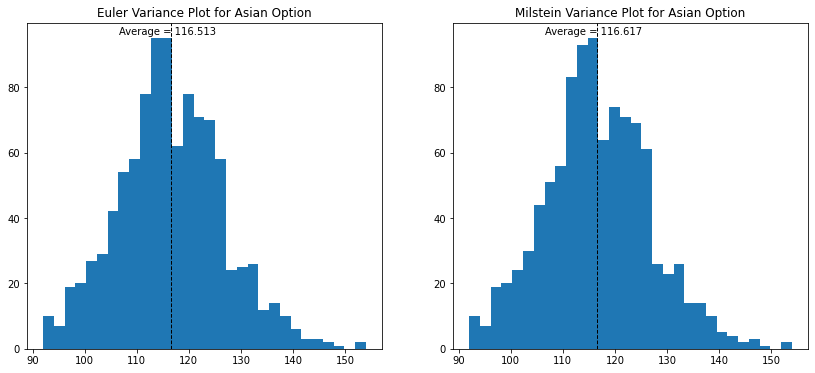

In [23]:
# Histogram of the Variance 
fig = plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Euler Variance Plot for Asian Option")
plt.hist(euler_asian_data, bins = 30)
plt.axvline(euler_asian_data[-1], color='k', linestyle='dashed', linewidth=1)
plt.text(euler_asian_data[-1] - 10, 96, f'Average = {euler_asian_data[-1]}')
print("Average Euler Variance (GBM)=", euler_asian_data[-1])
print("Average Milstein Variance (GBM)=", milstein_asian_data[-1])

plt.subplot(1, 2, 2)
plt.title("Milstein Variance Plot for Asian Option")
plt.hist(milstein_asian_data, bins = 30)
plt.axvline(milstein_asian_data[-1], color='k', linestyle='dashed', linewidth=1)
plt.text(milstein_asian_data[-1] - 10, 96, f'Average = {milstein_asian_data[-1]}')
plt.show()

### Hypothesis Testing 
We would like to conduct hypothesis testing with a significance level of 0.05 to see if there are significant difference between the average variance of Euler and Milstein scheme. More explicitly, our null hypothesis is that there is no significant difference between the variance of Euler and Milstein Scheme.

In [25]:
euler = euler_asian_data[:-1]
milstein = milstein_asian_data[:-1]

euler_mean = np.mean(euler)
euler_std = np.std(euler)
print(f"Euler: mean = {euler_mean}, sd = {euler_std}")

milstein_mean = np.mean(milstein)
milstein_std = np.std(milstein)
print(f"Milstein: mean = {milstein_mean}, sd = {milstein_std}")

ttest,pval = ttest_ind(euler, milstein)
print("p-value", pval)

if pval < 0.05:
    print("We reject null hypothesis.")
else: 
    print("We fail to reject the null hypothesis.")

Euler: mean = 116.513, sd = 10.124022471330257
Milstein: mean = 116.617, sd = 10.138851562183953
p-value 0.8185665311789814
We fail to reject the null hypothesis.


## Stochastic Volatility Model (SVM)

SVM assumes that the volatility of the asset prices fluctuates over time, unlike in Black Scholes model. This corrects the inefficiencies and pricing errors in models that assumes constant volatility, which is unlikely to be the case in real life. A few distinct characteristics of Heston's model is that 

* factors in possible correlation between a stock's price and its volatility 
* conveys volatility as reverting to the mean 
* closed-form solution - answer is derived from an accepted set of mathematical operations 
* does not require stock prices follow a lognormal probability distribution 

ref: <https://www.investopedia.com/terms/h/heston-model.asp>

SVM takes the form of 

$$S_{t+h} - S_t = rS_th + \sqrt{V_t}S_t\sqrt{h}Z^1$$
$$V_{t+h} - V_t = k(\theta - V_t)h + \sigma\sqrt{V_t}\sqrt{h}Z^2$$

such that $Z^1, Z^2 \sim N(0, 1)$, and 

$S_t$ = asset price at time t \
$r$ = risk-free interest rate \
$\sqrt{V_t}$ = volatility or standard devaition of the asset price \
$\sigma$ = volatility of $\sqrt{V_t}$ \
$\theta$ = long-term price variance \
$k$ = rate of reversion to $\theta$ \
$dt$ = time step size \
$Z_1$ = Brownian motion of the asset price \
$Z_2$ = Brownian motion of the asset's price variance



For benchmarking purpose, I found an implementation of SVM on <https://towardsdatascience.com/stochastic-volatility-pricing-in-python-931f4b03d793> to compare our results to with the parameters stated below. The result centers around 14. 

In [91]:
S = 100
r = .05
X= 110
n = 1000
vt = .09
T = 1
dt = 1/252
rho = -.7
alpha = .5
beta = 2
sigma_var = .3
call = True
payoffs = []

for i in range(0, n):

    St = S
    inst_var_now = vt
    prev_inst_var = inst_var_now
    step = 0

    while(step < T):
        e1 = np.random.randn()
        e2 = e1 * rho + np.sqrt(1 - (rho ** 2)) * np.random.randn()

        St = St + r * St * dt + St * np.sqrt(prev_inst_var * dt) * e1

        prev_inst_var = inst_var_now

        inst_var_now = prev_inst_var + (alpha - beta * prev_inst_var) * dt + sigma_var * np.sqrt(prev_inst_var * dt) * e2

        if inst_var_now > 0.0000001:
            pass
        else:
            inst_var_now = 0.0000001
        step += dt

    payoff = 0

    if call:
        if St > X:
            payoff += (St - X)
        else:
            payoff = 0
    if not call:
        if  St < X:
            payoff += (X - St)
        else:
            payoff = 0

    payoffs.append((payoff *np.exp(-r * T)))

print(np.average(payoffs))

13.919109956754355


### Euler Scheme (European)

In [12]:
## Implementation 1: our original code 
def euro_euler_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    f = []
    
    for j in range(n):
        t = 0 
        x = x0 
        v = v0
#         m = int(math.floor(T/h)) 
        m = int(T/h) 
        
        for k in range(m):
            dw1 = np.random.normal(0, 1, 1)
            dw2 = np.random.normal(0, 1, 1)
            dw3 = rho*dw1 + math.sqrt(1-rho**2)*dw2 #z1 and z3 are correlated with coefficient rho, z3 ~ N(0,1)
            x = x + r*x*h + math.sqrt(v)*x*math.sqrt(h)*dw1
            if v < 0:
                v = 0
            else:
                v = v + k*(theta-v)*h + sigma*math.sqrt(v)*math.sqrt(h)*dw3
            t = t + h 
        
        if optiontype == "call":
            f += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(x, r, T, K)]
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI
    
#     print(f"Expected Price = {theta}")
#     print(f"Variance = {variance}")
#     print(f"CI = {CI}")

In [14]:
# Comparing our model with model from https://towardsdatascience.com/stochastic-volatility-pricing-in-python-931f4b03d793
# which gives us a value of 14.648.
print("Euler scheme")
euro_euler_svm(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)

Euler scheme


(array([17.60760592]), array([1518.79089548]), (15, 20))

### Milstein Scheme (European) 

In [17]:
def euro_milstein_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    f = []
    
    for j in range(n):
        t = 0 
        x = x0 
        v = v0
        m = int(math.floor(T/h))
        
        for k in range(m):
            dw1 = np.random.normal(0, 1, 1)
            dw2 = np.random.normal(0, 1, 1)
            dw3 = rho*dw1 + math.sqrt(1-rho**2)*dw2 
            x = x + r*x*h + math.sqrt(v)*x*math.sqrt(h)*dw1 + 0.5*v*x*h*(dw1**2 - 1)
            v = v + k*(theta-v)*h + sigma*math.sqrt(v)*math.sqrt(h)*dw3 + 0.5*sigma*sigma*math.sqrt(v)*h*(dw3**2 - 1)
            t = t + h 
        
        if optiontype == "call":
            f += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(x, r, T, K)]
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI
    
#     print(f"Expected Price = {theta}")
#     print(f"Variance = {variance}")
#     print(f"CI = {CI}")

In [281]:
print("Milstein scheme")
euro_milstein_svm(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)

Milstein scheme


(array([16.54486698]), array([1331.48234906]), (14, 18))

### Average Variance 

In [104]:
# Implementation of 1000 runs of Euler scheme
np.random.seed(1)
def euro_euler_svm1000(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    variance = []
    for i in range(1000):
        variance.append(int(euro_euler_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call")[1]))
    expected_variance = sum(variance)/1000
    variance.append(expected_variance)
    return variance

euro_euler_svm_data = euro_euler_svm1000(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)
print(euro_euler_svm_data)

<ipython-input-73-3fdcff3d59e1>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


[1603, 1540, 1248, 1561, 1343, 1398, 1285, 1278, 1214, 1148, 1288, 1262, 1181, 1225, 1316, 1775, 1469, 1395, 1439, 1303, 1168, 1342, 1460, 1327, 1269, 1268, 1342, 1075, 1508, 1469, 1296, 1291, 1338, 1385, 1686, 1513, 1341, 1210, 1383, 1246, 1381, 1199, 1213, 1107, 1469, 1424, 1292, 1163, 1195, 920, 1556, 1377, 1084, 1399, 1615, 1018, 1573, 1429, 1543, 1365, 1144, 1296, 922, 1130, 1308, 1570, 1243, 1433, 1152, 1405, 1423, 1237, 1222, 1319, 1526, 1487, 1616, 1408, 1289, 1411, 1292, 1856, 1604, 1449, 1343, 1117, 1445, 1391, 1324, 1202, 1314, 1485, 1197, 1315, 1083, 1304, 1267, 1716, 1264, 1336, 1857, 1023, 1196, 1147, 1254, 1473, 1446, 1107, 1278, 1282, 1390, 1270, 1069, 1175, 1489, 1439, 1210, 1028, 1173, 1340, 1346, 1398, 1512, 1322, 1141, 1532, 1642, 1147, 1288, 1136, 1474, 1516, 1369, 1413, 1174, 1281, 1438, 1657, 1568, 1455, 1524, 1462, 1259, 1228, 1233, 1279, 1359, 1303, 1839, 1503, 1308, 1153, 1243, 1344, 1712, 1397, 1239, 1146, 1555, 1397, 991, 1108, 1218, 1612, 1680, 1298, 1153, 

In [ ]:
# Save results to excel 
book = xlwt.Workbook()
sheet1 = book.add_sheet('sheet1')

for i,e in enumerate(euro_euler_svm_data):
    sheet1.write(i,1,e)

name = "euro_euler_svm_data.xls"
book.save(name)
book.save(TemporaryFile())

In [113]:
# Implementation of 1000 runs of Milstein scheme
np.random.seed(1)
def euro_milstein_svm1000(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    variance = []
    for i in range(1000):
        variance.append(int(euro_milstein_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call")[1]))
    expected_variance = sum(variance)/1000
    variance.append(expected_variance)
    return variance

euro_milstein_svm_data = euro_milstein_svm1000(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)
print(euro_milstein_svm_data)

<ipython-input-109-e6c79b35a27e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


[1601, 1559, 1252, 1589, 1340, 1398, 1289, 1279, 1213, 1151, 1297, 1265, 1197, 1223, 1319, 1783, 1473, 1404, 1437, 1302, 1172, 1348, 1461, 1325, 1271, 1268, 1351, 1071, 1512, 1474, 1304, 1302, 1346, 1393, 1685, 1511, 1334, 1206, 1392, 1249, 1378, 1203, 1220, 1106, 1463, 1443, 1299, 1167, 1200, 918, 1563, 1385, 1090, 1397, 1618, 1021, 1576, 1427, 1562, 1369, 1152, 1309, 928, 1130, 1316, 1567, 1245, 1437, 1153, 1394, 1427, 1249, 1234, 1324, 1531, 1486, 1611, 1404, 1284, 1420, 1289, 1872, 1612, 1445, 1344, 1114, 1448, 1396, 1322, 1208, 1309, 1485, 1204, 1315, 1080, 1310, 1277, 1728, 1272, 1341, 1866, 1023, 1203, 1154, 1265, 1476, 1443, 1115, 1287, 1276, 1404, 1276, 1071, 1182, 1485, 1440, 1212, 1024, 1178, 1345, 1344, 1391, 1512, 1316, 1143, 1535, 1639, 1148, 1291, 1136, 1468, 1517, 1379, 1410, 1165, 1281, 1436, 1678, 1569, 1460, 1529, 1471, 1258, 1229, 1239, 1286, 1363, 1303, 1865, 1489, 1306, 1150, 1234, 1345, 1712, 1395, 1242, 1150, 1559, 1392, 999, 1102, 1210, 1617, 1678, 1297, 1150, 

In [114]:
# Save results to excel 
book = xlwt.Workbook()
sheet2 = book.add_sheet('sheet2')

for i,e in enumerate(euro_milstein_svm_data):
    sheet2.write(i,1,e)

name = "euro_milstein_svm_data.xls"
book.save(name)
book.save(TemporaryFile())

In [18]:
# Converting our saved results to a list 

euler = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/euro_euler_svm_data.xls")
euro_euler_svm_data = euler["Variance Value"].to_list()

milstein = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/euro_milstein_svm_data.xls")
euro_milstein_svm_data = milstein["Variance Value"].to_list()

Average Euler Variance = 1356.87
Average Milstein Variance = 1360.13


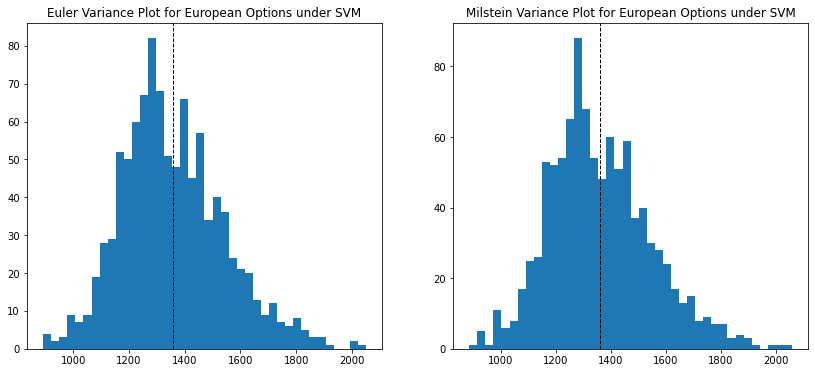

In [19]:
def average(l):
    return sum(l) / len(l)

fig = plt.figure(figsize=(14, 6))

print("Average Euler Variance =", euro_euler_svm_data[-1])
print("Average Milstein Variance =", euro_milstein_svm_data[-1])


plt.subplot(1, 2, 1)
plt.title("Euler Variance Plot for European Options under SVM")
plt.hist(euro_euler_svm_data, bins = 40)
plt.axvline(euro_euler_svm_data[-1], color='k', linestyle='dashed', linewidth=1)

plt.subplot(1, 2, 2)
plt.title("Milstein Variance Plot for European Options under SVM")
plt.hist(euro_milstein_svm_data, bins = 40)
plt.axvline(euro_milstein_svm_data[-1], color='k', linestyle='dashed', linewidth=1)
plt.show()


### Hypothesis Testing 

In [20]:
euler = euro_euler_svm_data[:-1]
milstein = euro_milstein_svm_data[:-1]

euler_mean = np.mean(euler)
euler_std = np.std(euler)
print(f"Euler: mean = {euler_mean}, sd = {euler_std}")

milstein_mean = np.mean(milstein)
milstein_std = np.std(milstein)
print(f"Milstein: mean = {milstein_mean}, sd = {milstein_std}")

ttest,pval = ttest_ind(euler, milstein)
print("p-value", pval)

if pval < 0.05:
    print("We reject null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

Euler: mean = 1356.87, sd = 183.90272727722117
Milstein: mean = 1360.126, sd = 184.97002493377136
p-value 0.6932159926506682
We fail to reject the null hypothesis.


### Euler (Asian Options)

In [287]:
## Implementation 1: our original code 
def asian_euler_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    f = []
    t = []
    
    for j in range(n):
        t = 0 
        x = x0 
        v = v0
        m = int(math.floor(T/h))
        
        price = []
        for k in range(m):
            dw1 = np.random.normal(0, 1, 1)
            dw2 = np.random.normal(0, 1, 1)
            dw3 = rho*dw1 + math.sqrt(1-rho**2)*dw2 #z1 and z3 are correlated with coefficient rho, z3 ~ N(0,1)
            x = x + r*x*h + math.sqrt(v)*x*math.sqrt(h)*dw1
            price.append(x)
            v = v + k*(theta-v)*h + sigma*math.sqrt(v)*math.sqrt(h)*dw3
            t = t + h 
        
        avg = average(price)
        if optiontype == "call":
            f += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(avg, r, T, K)]
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI

In [291]:
print("Euler scheme")
asian_euler_svm(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)

Euler scheme


(array([6.41773271]), array([205.85313422]), (5, 7))

### Milstein (Asian Options)

In [289]:
def asian_milstein_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    f = []
    t = []
    
    for j in range(n):
        t = 0 
        x = x0 
        v = v0
        m = int(math.floor(T/h))
        
        price = []
        for k in range(m):
            dw1 = np.random.normal(0, 1, 1)
            dw2 = np.random.normal(0, 1, 1)
            dw3 = rho*dw1 + math.sqrt(1-rho**2)*dw2 
            x = x + r*x*h + math.sqrt(v)*x*math.sqrt(h)*dw1 + 0.5*v*x*h*(dw1**2 - 1)
            price.append(x)
            v = v + k*(theta-v)*h + sigma*math.sqrt(v)*math.sqrt(h)*dw3 + 0.5*sigma*sigma*math.sqrt(v)*h*(dw3**2 - 1)
            t = t + h 
        
        avg = average(price)
        if optiontype == "call":
            f += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f += [put_option_price(avg, r, T, K)]
    
    theta = np.sum(f)/n
    
    variance = np.sum((f - theta)**2)/(n-1)
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI
    
#     print(f"Expected Price = {theta}")
#     print(f"Variance = {variance}")
#     print(f"CI = {CI}")

In [292]:
print("Milstein scheme")
asian_milstein_svm(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)

Milstein scheme


(array([7.04473763]), array([206.43237625]), (6, 7))

### Average Variance 

In [190]:
# Implementation of 1000 runs of Euler scheme
np.random.seed(1)
def asian_euler_svm1000(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    variance = []
    for i in range(1000):
        variance.append(int(asian_euler_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call")[1]))
    expected_variance = sum(variance)/1000
    variance.append(expected_variance)
    return variance

asian_euler_svm_data = asian_euler_svm1000(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)
print(asian_euler_svm_data)

<ipython-input-163-5f11923dfce2>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


[288, 286, 284, 291, 293, 274, 256, 243, 280, 227, 278, 243, 230, 250, 245, 323, 326, 269, 276, 235, 222, 270, 343, 267, 258, 259, 289, 259, 276, 284, 275, 293, 275, 309, 298, 340, 315, 245, 269, 303, 290, 234, 274, 250, 236, 284, 265, 223, 259, 175, 325, 277, 228, 291, 335, 212, 288, 303, 294, 248, 233, 275, 198, 230, 261, 317, 251, 270, 220, 285, 237, 278, 226, 304, 324, 289, 323, 283, 237, 284, 242, 348, 332, 320, 273, 234, 284, 272, 263, 256, 255, 313, 254, 252, 225, 266, 247, 325, 258, 296, 385, 246, 282, 237, 283, 296, 282, 261, 285, 276, 243, 240, 230, 241, 315, 328, 219, 222, 277, 272, 238, 282, 325, 278, 238, 307, 308, 279, 280, 251, 284, 288, 311, 292, 230, 269, 267, 313, 304, 270, 307, 253, 267, 242, 266, 275, 270, 253, 333, 318, 278, 228, 272, 278, 335, 294, 248, 256, 325, 286, 200, 242, 241, 342, 310, 275, 250, 236, 232, 282, 277, 195, 293, 255, 292, 305, 284, 275, 233, 259, 353, 272, 230, 265, 272, 245, 288, 333, 296, 347, 342, 241, 301, 282, 260, 249, 250, 293, 208, 277,

In [191]:
# Save results to excel 
book = xlwt.Workbook()
sheet1 = book.add_sheet('sheet1')

for i,e in enumerate(asian_euler_svm_data):
    sheet1.write(i,1,e)

name = "asian_euler_svm_data.xls"
book.save(name)
book.save(TemporaryFile())

In [194]:
# Implementation of 1000 runs of Milstein scheme
np.random.seed(1)
def asian_milstein_svm1000(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call"):
    variance = []
    for i in range(1000):
        variance.append(int(asian_milstein_svm(x0, r, T, K, h, n, v0, k, sigma, alpha, theta, rho, optiontype = "call")[1]))
    expected_variance = sum(variance)/1000
    variance.append(expected_variance)
    return variance

asian_milstein_svm_data = asian_milstein_svm1000(100, 0.05, 1, 110, 1/252, 1000, 0.09, 2, 0.3, 0.05, 0.5/2, -0.7)
print(asian_milstein_svm_data)

<ipython-input-166-3912a0af40f4>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variance = np.sum((f - theta)**2)/(n-1)


[288, 290, 284, 293, 294, 274, 255, 244, 280, 228, 281, 243, 232, 251, 246, 324, 327, 270, 276, 236, 223, 271, 342, 267, 259, 260, 290, 258, 275, 284, 276, 295, 275, 309, 300, 341, 314, 244, 271, 305, 292, 234, 275, 250, 235, 287, 266, 224, 261, 175, 326, 277, 229, 291, 335, 213, 288, 304, 297, 248, 233, 277, 198, 231, 263, 318, 252, 270, 222, 284, 238, 281, 228, 306, 326, 289, 323, 283, 236, 286, 242, 351, 334, 321, 274, 233, 284, 273, 264, 258, 254, 314, 255, 252, 224, 267, 248, 327, 260, 297, 388, 247, 284, 238, 285, 297, 284, 263, 285, 275, 244, 242, 230, 243, 315, 329, 219, 220, 278, 274, 238, 282, 326, 277, 238, 308, 309, 279, 281, 251, 285, 288, 314, 292, 229, 270, 267, 317, 304, 270, 308, 254, 267, 243, 267, 278, 272, 254, 336, 318, 278, 228, 271, 280, 335, 295, 249, 258, 325, 286, 201, 242, 241, 343, 311, 276, 251, 239, 233, 284, 277, 196, 293, 255, 292, 306, 286, 274, 236, 258, 353, 272, 232, 265, 272, 245, 291, 334, 297, 349, 346, 243, 302, 284, 260, 250, 249, 293, 209, 278,

In [195]:
# Save results to excel 
book = xlwt.Workbook()
sheet2 = book.add_sheet('sheet2')

for i,e in enumerate(asian_milstein_svm_data):
    sheet2.write(i,1,e)

name = "asian_milstein_svm_data.xls"
book.save(name)
book.save(TemporaryFile())

In [295]:
# Converting our saved results to a list 

euler = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/asian_euler_svm_data.xls")
asian_euler_svm_data = euler["Variance Value"].to_list()

milstein = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/asian_milstein_svm_data.xls")
asian_milstein_svm_data = milstein["Variance Value"].to_list()

Average Euler Variance = 272.69
Average Milstein Variance = 273.603


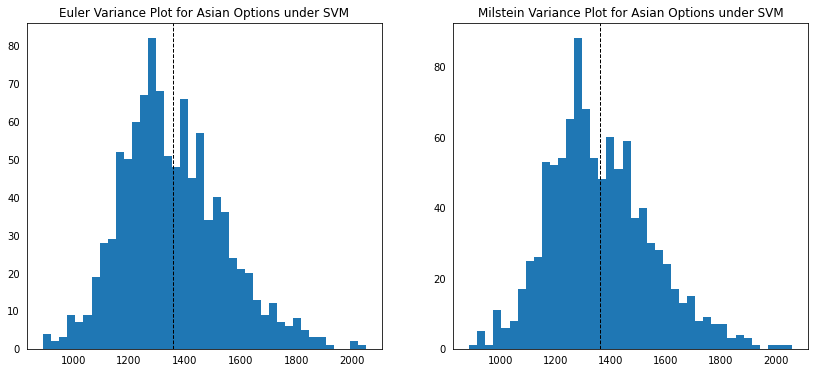

In [296]:
def average(l):
    return sum(l) / len(l)

fig = plt.figure(figsize=(14, 6))

print("Average Euler Variance =", asian_euler_svm_data[-1])
print("Average Milstein Variance =", asian_milstein_svm_data[-1])

plt.subplot(1, 2, 1)
plt.title("Euler Variance Plot for Asian Options under SVM")
plt.hist(euro_euler_svm_data, bins = 40)
plt.axvline(euro_euler_svm_data[-1], color='k', linestyle='dashed', linewidth=1)

plt.subplot(1, 2, 2)
plt.title("Milstein Variance Plot for Asian Options under SVM")
plt.hist(euro_milstein_svm_data, bins = 40)
plt.axvline(euro_milstein_svm_data[-1], color='k', linestyle='dashed', linewidth=1)
plt.show()


### Hypothesis Testing

In [297]:
euler = asian_euler_svm_data[:-1]
milstein = asian_milstein_svm_data[:-1]

euler_mean = np.mean(euler)
euler_std = np.std(euler)
print(f"Euler: mean = {euler_mean}, sd = {euler_std}")

milstein_mean = np.mean(milstein)
milstein_std = np.std(milstein)
print(f"Milstein: mean = {milstein_mean}, sd = {milstein_std}")

ttest,pval = ttest_ind(euler, milstein)
print("p-value", pval)

if pval < 0.05:
    print("We reject null hypothesis. ")
else:
    print("We fail to reject the null hypothesis.")

Euler: mean = 272.69, sd = 33.74270143305068
Milstein: mean = 273.603, sd = 33.964501924803784
p-value 0.5467488707486297
We fail to reject the null hypothesis.


## GBM with Richardson Extrapolation

### Euler Scheme (European Options)

The Euler Scheme with Richardson Extrapolation usually has superior performance to the second order schemes, especially in high dimensions. Hence, this scheme is usually considered to be the benchmark scheme for reducing discretizing error. 

In [199]:
def euro_euler_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    
    ## Simulate with time step h
    f1 = []
    t1 = []
    
#     np.random.seed(10)
    # simulate n paths 
    for j in range(n):
        t1 = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*h + sigma*x*math.sqrt(h)*z # price of asset 
            price.append(x) 
            t1 = t1 + h 
        
        if optiontype == "call":
            f1 += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f1 += [put_option_price(x, r, T, K)]
    
    #print(f1)
    theta1 = np.sum(f1)/n
    var1 = np.sum((f1 - theta1)**2)/(n-1)
    
    ## Simulate with time step 2h 
    f2 = []
    t2 = []
    
    # simulate n paths 
#     np.random.seed(10)
    for j in range(n):
        t2 = 0 
        x = x0 
        m = int(math.floor(T/(2*h)))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*(2*h) + sigma*x*math.sqrt(2*h)*z # price of asset 
          
        if optiontype == "call":
            f2 += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f2 += [put_option_price(x, r, T, K)]
        
    theta2 = np.sum(f2)/n
    var2 = np.sum((f2 - theta2)**2)/(n-1)
    
    ## compiled variables 
    theta = 2*theta1 - theta2
    variance = np.sum(((2*a - b - theta)**2)/(n-1) for (a, b) in zip(f1, f2))
    cov = sum((a - theta1) * (b - theta2) for (a,b) in zip(f1,f2)) / len(f1) 
    print("cov =", cov)
#     variance = 4*var1 + var2 - 4*cov
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI

# why is my variance so huge? variance reduction will be obtaiend if covariance term is positive 

In [200]:
print("Euler Scheme with Richardson Extrapolation")
euro_euler_richardson(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")

Euler Scheme with Richardson Extrapolation
cov = [-1.55903687]


(array([12.35149541]), array([2165.7571121]), (9, 15))

### Milstein Scheme (European Options)

In [201]:
def euro_milstein_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    
    ## Simulate with time step h
    f1 = []
    t1 = []
    
    # simulate n paths 
    for j in range(n):
        t1 = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x = x + r*x*h + sigma*x*math.sqrt(h)*z + 0.5*sigma*sigma*x*h*(z**2 - 1)
#             price.append(x)
#             t1 = t1 + h 
        
    
        if optiontype == "call":
            f1 += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f1 += [put_option_price(x, r, T, K)] 
        
    theta1 = np.sum(f1)/n
    var1 = np.sum((f1 - theta1)**2)/(n-1)
#     print("var1 =", var1)
    
    ## Simulate with time step 2h 
    f2 = []
    t2 = []
    
    # simulate n paths 
    for j in range(n):
        t2 = 0 
        x = x0 
        m = int(math.floor(T/(2*h)))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x = x + r*x*(2*h) + sigma*x*math.sqrt(2*h)*z + 0.5*sigma*sigma*x*(2*h)*(z**2 - 1)
#             price.append(x)
#             t2 = t2 + 2*h 
          
        if optiontype == "call":
            f2 += [call_option_price(x, r, T, K)] # price of options
        elif optiontype == "put":
            f2 += [put_option_price(x, r, T, K)]
        
    theta2 = np.sum(f2)/n
    var2 = np.sum((f2 - theta2)**2)/(n-1)
#     print("var2 =", var2)
    
    ## compiled variables 
    theta = 2*theta1 - theta2
    #Michael
#     print(f1)
    variance = np.sum(((2*a - b - theta)**2)/(n-1) for (a, b) in zip(f1, f2))
    cov = sum((a - theta1) * (b - theta2) for (a, b) in zip(f1, f2)) / len(f1)
    print("cov =", cov)
#     variance = 4*var1 + var2 - 4*cov
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI

# why is my variance so huge?

In [202]:
# Test example 
print("Milstein with Ricahrdson Extrapolation")
euro_milstein_richardson(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")

Milstein with Ricahrdson Extrapolation
cov = [-11.7616113]


(array([10.52062386]), array([1893.30684238]), (7, 13))

### Average Variance

In [235]:
# # Implementation of 1000 runs of Euler scheme
# np.random.seed(1)
# def euro_euler_richardson1000(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
#     variance = []
#     for i in range(1000):
#         variance.append(int(euro_euler_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call")[1]))
#     expected_variance = sum(variance)/1000
#     variance.append(expected_variance)
#     return variance

# euro_euler_richardson_data = euro_euler_richardson1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")
# print(euro_euler_richardson_data)

<ipython-input-230-ffa86fdc64d8>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var1 = np.sum((f1 - theta1)**2)/(n-1)
<ipython-input-230-ffa86fdc64d8>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var2 = np.sum((f2 - theta2)**2)/(n-1)
<ipython-input-230-ffa86fdc64d8>:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  variance = np.sum(((2*a - b - theta)**2)/(n-1) for (a, b) in zip(f1, f2))


[1993, 1652, 2057, 2192, 1878, 1712, 1909, 2126, 1872, 1993, 1989, 2068, 2105, 1693, 1863, 2258, 1798, 2065, 2139, 2080, 2301, 1970, 2215, 2172, 2049, 2147, 1932, 1934, 1804, 1846, 1932, 1897, 1939, 1509, 1939, 1697, 2007, 1679, 2034, 2039, 2088, 1870, 1657, 2028, 2011, 1840, 2050, 2162, 1766, 1551, 1992, 1825, 1961, 2076, 2159, 2065, 2120, 1534, 1991, 1948, 1942, 2053, 1856, 1684, 1829, 2178, 1960, 2048, 1847, 1716, 1951, 1780, 1875, 1979, 1989, 2032, 2002, 1718, 1935, 1914, 1945, 1730, 2191, 1892, 2178, 1978, 2410, 1876, 2032, 2167, 1773, 1863, 1903, 1647, 1799, 1975, 1758, 1703, 1689, 1812, 1980, 2115, 1911, 1976, 1918, 1595, 2181, 2027, 1854, 2066, 1985, 1929, 1831, 1905, 1802, 1822, 1626, 2065, 2010, 1888, 1841, 1759, 2107, 1940, 1982, 2422, 1761, 2144, 1990, 1844, 1988, 2216, 2082, 1617, 2007, 2094, 1738, 1776, 1928, 2132, 1765, 2086, 1732, 1985, 2147, 1860, 1813, 1751, 1998, 1656, 1966, 1942, 1795, 1885, 1743, 2170, 1833, 1863, 1998, 1864, 2286, 1878, 1890, 1848, 2024, 1778, 214

In [162]:
# # Save results to excel 
# book = xlwt.Workbook()
# sheet1 = book.add_sheet('sheet1')

# for i,e in enumerate(euro_euler_richardson_data):
#     sheet1.write(i,1,e)

# name = "euro_euler_richardson_data.xls"
# book.save(name)
# book.save(TemporaryFile())

NameError: name 'euro_euler_richardson_data' is not defined

In [214]:
# # Implementation of 1000 runs of Milstein scheme
# np.random.seed(1)
# def euro_milstein_richardson1000(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
#     variance = []
#     for i in range(1000):
#         variance.append(int(euro_milstein_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call")[1]))
#     expected_variance = sum(variance)/1000
#     variance.append(expected_variance)
#     return variance

# euro_milstein_richardson_data = euro_milstein_richardson1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")
# print(euro_milstein_richardson_data)

<ipython-input-202-a4dc4c9b3d1a>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var1 = np.sum((f1 - theta1)**2)/(n-1)
<ipython-input-202-a4dc4c9b3d1a>:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var2 = np.sum((f2 - theta2)**2)/(n-1)
<ipython-input-202-a4dc4c9b3d1a>:62: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  variance = np.sum(((2*a - b - theta)**2)/(n-1) for (a, b) in zip(f1, f2))


[1995, 1652, 2060, 2200, 1882, 1712, 1911, 2129, 1875, 2000, 1988, 2067, 2103, 1696, 1863, 2262, 1800, 2068, 2144, 2086, 2299, 1974, 2213, 2177, 2049, 2150, 1935, 1938, 1806, 1847, 1935, 1900, 1942, 1511, 1943, 1699, 2008, 1686, 2038, 2041, 2088, 1873, 1658, 2030, 2013, 1840, 2056, 2162, 1768, 1550, 1995, 1829, 1954, 2080, 2162, 2065, 2124, 1535, 1990, 1950, 1943, 2054, 1859, 1686, 1827, 2182, 1959, 2048, 1849, 1717, 1957, 1783, 1879, 1980, 1996, 2033, 2007, 1721, 1934, 1913, 1948, 1730, 2196, 1889, 2179, 1982, 2407, 1874, 2035, 2165, 1775, 1865, 1905, 1647, 1797, 1977, 1757, 1706, 1691, 1818, 1979, 2115, 1913, 1978, 1915, 1594, 2184, 2027, 1855, 2067, 1990, 1932, 1833, 1907, 1802, 1821, 1628, 2066, 2013, 1888, 1841, 1759, 2109, 1945, 1982, 2426, 1763, 2146, 1993, 1844, 1992, 2220, 2080, 1619, 2008, 2095, 1740, 1782, 1928, 2134, 1766, 2086, 1732, 1991, 2151, 1864, 1809, 1754, 1995, 1659, 1969, 1942, 1793, 1888, 1742, 2171, 1836, 1864, 1996, 1864, 2290, 1879, 1893, 1852, 2023, 1780, 214

In [203]:
euro_euler_richardson_data = [1993, 1652, 2057, 2192, 1878, 1712, 1909, 2126, 1872, 1993, 1989, 2068, 2105, 1693, 1863, 2258, 1798, 2065, 2139, 2080, 2301, 1970, 2215, 2172, 2049, 2147, 1932, 1934, 1804, 1846, 1932, 1897, 1939, 1509, 1939, 1697, 2007, 1679, 2034, 2039, 2088, 1870, 1657, 2028, 2011, 1840, 2050, 2162, 1766, 1551, 1992, 1825, 1961, 2076, 2159, 2065, 2120, 1534, 1991, 1948, 1942, 2053, 1856, 1684, 1829, 2178, 1960, 2048, 1847, 1716, 1951, 1780, 1875, 1979, 1989, 2032, 2002, 1718, 1935, 1914, 1945, 1730, 2191, 1892, 2178, 1978, 2410, 1876, 2032, 2167, 1773, 1863, 1903, 1647, 1799, 1975, 1758, 1703, 1689, 1812, 1980, 2115, 1911, 1976, 1918, 1595, 2181, 2027, 1854, 2066, 1985, 1929, 1831, 1905, 1802, 1822, 1626, 2065, 2010, 1888, 1841, 1759, 2107, 1940, 1982, 2422, 1761, 2144, 1990, 1844, 1988, 2216, 2082, 1617, 2007, 2094, 1738, 1776, 1928, 2132, 1765, 2086, 1732, 1985, 2147, 1860, 1813, 1751, 1998, 1656, 1966, 1942, 1795, 1885, 1743, 2170, 1833, 1863, 1998, 1864, 2286, 1878, 1890, 1848, 2024, 1778, 2142, 1541, 1979, 2252, 2006, 2055, 2207, 2052, 1901, 1861, 2107, 1974, 2037, 2050, 2030, 2222, 1943, 1885, 2064, 1853, 2128, 1887, 1892, 1940, 1949, 1841, 2069, 1932, 1413, 2031, 1970, 1716, 1906, 1969, 1943, 2074, 1944, 1948, 1857, 1740, 1735, 1954, 2023, 1889, 2012, 2136, 1720, 2062, 1703, 2346, 1845, 1653, 1916, 1873, 1873, 2156, 1835, 1941, 1891, 1879, 2003, 2223, 1961, 1823, 1788, 2032, 2108, 1727, 2141, 2067, 1949, 2143, 1972, 2000, 1900, 1764, 1954, 1976, 1784, 1962, 1670, 2036, 2066, 1971, 1973, 2161, 2020, 2012, 1842, 1921, 2164, 1935, 2181, 1869, 2046, 1928, 1970, 2346, 1788, 1774, 2376, 1842, 1886, 2230, 2431, 2126, 1834, 2074, 2061, 1830, 2098, 2157, 1843, 1976, 1931, 1883, 2236, 2169, 1753, 1849, 1829, 2062, 1875, 2063, 1784, 2078, 1980, 2172, 1907, 2178, 1995, 2047, 1947, 2129, 2060, 2004, 1908, 1914, 1836, 1827, 1984, 1983, 2007, 1860, 2130, 2142, 2060, 2038, 1824, 2130, 1717, 2071, 2008, 1853, 2062, 1947, 1686, 2034, 1533, 2026, 1839, 1921, 1710, 2058, 1711, 2124, 2065, 2021, 1822, 1912, 2106, 1760, 2004, 2245, 1815, 1824, 1765, 1996, 2003, 1896, 1885, 1638, 1908, 2434, 1874, 1969, 1642, 2150, 2016, 2054, 1880, 1867, 1909, 2140, 2395, 1881, 1964, 1964, 1831, 2250, 1829, 2142, 1762, 1789, 2064, 1745, 1716, 2150, 1727, 2059, 1775, 1878, 1747, 1910, 1644, 2015, 1694, 2084, 2017, 1983, 2256, 1906, 2320, 1907, 1720, 1822, 1919, 1778, 2407, 2026, 1861, 1861, 2002, 1869, 2210, 1568, 2004, 1913, 2088, 1786, 1914, 1802, 1807, 1918, 1904, 2050, 2029, 1822, 1876, 1825, 1989, 2134, 1772, 2013, 2040, 1848, 2124, 2094, 2118, 2063, 2026, 1891, 1837, 2137, 1875, 2101, 2271, 1976, 1967, 1547, 1835, 2156, 1908, 1960, 1733, 1953, 2000, 1860, 1820, 2019, 2256, 1972, 1888, 1901, 1880, 2063, 2096, 2384, 1893, 1907, 1718, 1807, 1771, 1923, 1940, 1998, 1949, 1885, 1613, 2064, 1864, 1946, 1743, 1803, 1930, 2051, 1999, 2093, 2001, 1990, 2051, 2190, 1796, 1892, 2010, 1568, 1754, 2025, 2185, 1814, 1707, 1907, 1736, 1878, 1775, 1989, 1799, 2065, 1892, 1639, 2101, 1814, 1799, 1793, 2048, 1905, 1898, 2196, 1786, 1791, 1811, 2012, 2039, 2006, 1855, 2082, 1816, 1760, 2002, 1875, 1957, 1504, 1894, 1915, 1855, 1866, 1812, 2218, 1878, 1995, 1887, 2179, 2067, 1971, 1779, 1681, 2188, 2062, 1905, 2128, 1852, 2050, 1802, 2119, 2022, 1830, 1662, 2058, 1893, 1919, 2187, 1984, 1717, 2045, 2055, 2099, 2346, 1864, 2086, 2075, 2015, 1918, 1967, 2005, 2205, 1981, 2018, 1957, 2280, 1642, 1882, 2108, 1925, 1908, 2086, 2164, 1919, 1950, 1973, 2074, 2028, 2002, 2013, 2027, 1774, 1889, 1591, 1810, 2042, 2130, 1999, 1730, 1874, 1928, 2059, 2001, 2143, 2060, 2039, 2005, 2193, 2101, 2288, 1843, 2040, 1945, 1757, 1888, 2177, 1932, 1982, 1857, 2082, 2140, 1863, 1894, 2234, 1532, 1861, 1723, 2171, 2006, 1914, 2157, 1753, 1996, 1704, 1991, 2136, 1816, 2006, 1910, 1743, 2174, 1891, 1983, 1838, 2038, 1922, 1901, 2027, 1893, 1936, 2205, 1778, 1819, 2124, 2004, 1894, 2105, 1959, 2195, 2025, 1936, 1871, 1653, 1987, 1689, 1850, 1865, 1794, 2326, 1847, 1752, 1885, 1947, 1702, 2110, 2031, 2151, 1900, 2194, 2003, 1986, 2095, 1881, 1689, 2074, 1751, 1746, 1913, 1956, 1979, 2294, 1907, 1754, 1834, 1851, 1529, 1684, 1909, 1894, 1988, 1928, 2012, 1994, 1799, 1997, 1928, 2079, 1809, 1938, 1980, 1840, 1807, 1905, 1868, 1888, 2142, 1806, 1784, 1749, 2052, 2128, 2072, 2089, 2202, 1857, 1988, 2247, 1911, 1815, 2088, 2206, 2026, 1800, 2006, 2183, 2036, 1887, 2018, 1894, 2110, 1756, 2130, 1863, 2163, 1856, 1756, 1866, 2046, 1880, 1714, 1926, 2184, 1744, 2010, 1968, 1945, 2000, 1762, 1799, 1932, 1928, 1877, 1957, 2193, 1869, 1920, 1791, 1876, 1881, 1751, 1937, 2094, 1876, 1901, 1963, 2153, 1857, 2134, 2362, 1941, 1872, 1698, 2027, 2033, 1781, 1655, 2224, 2023, 2400, 1771, 2016, 1976, 1968, 1632, 2023, 1869, 1895, 2071, 2024, 2086, 2113, 1721, 2118, 1954, 1978, 2150, 1919, 2116, 1776, 2078, 2163, 1908, 1733, 1820, 1725, 1783, 1888, 2030, 1879, 1808, 1881, 1773, 2040, 1566, 1702, 1944, 2014, 1918, 1921, 1845, 2022, 1824, 1993, 1594, 1885, 2118, 1986, 1949, 1522, 2100, 1896, 1777, 2125, 2087, 1666, 1803, 1887, 2153, 1985, 2195, 2128, 1800, 2207, 1707, 2087, 1766, 2095, 1870, 1841, 2004, 1899, 1831, 1756, 2219, 1730, 1615, 2110, 1909, 2002, 1828, 1885, 1780, 1957, 2059, 1896, 1892, 1978, 1695, 1902, 2190, 1866, 1773, 2193, 1610, 1982, 2155, 1826, 1869, 2036, 1918, 2011, 2164, 2214, 2231, 2255, 2008, 1843, 2056, 1834, 1969, 1823, 1830, 2007, 1853, 1862, 2332, 2235, 2092, 1820, 1882, 1957, 1929, 1986, 2009, 2451, 2062, 2053, 1894, 1687, 1960, 1981, 1876, 1847, 1852, 1848, 2027, 1738, 1770, 1982, 1945, 2056, 2019, 2077, 2235, 2003, 1970, 2030, 2079, 2039, 1797, 1906, 1841, 1851, 1850, 1644, 1855, 1982, 1737, 2439, 1994, 1852, 1941, 2162, 1726, 1844, 1745, 1847, 2124, 1780, 2086, 1870, 2040, 2152, 1509, 1973, 1815, 2113, 2220, 1961, 1906, 2282, 2058, 2000, 1873, 1712, 1753, 1857, 1799, 2137, 2077, 1878, 2044, 2103, 2130, 1732, 2025, 1884, 1857, 2104, 1935, 2131, 2153, 1843, 1744, 2156, 1872, 1754, 2085, 2021, 2095, 2145, 2030, 2000, 1815, 1985, 1787, 2048, 1740, 1724, 1644, 2013, 1947.298]

In [204]:
euro_milstein_richardson_data = [1995, 1652, 2060, 2200, 1882, 1712, 1911, 2129, 1875, 2000, 1988, 2067, 2103, 1696, 1863, 2262, 1800, 2068, 2144, 2086, 2299, 1974, 2213, 2177, 2049, 2150, 1935, 1938, 1806, 1847, 1935, 1900, 1942, 1511, 1943, 1699, 2008, 1686, 2038, 2041, 2088, 1873, 1658, 2030, 2013, 1840, 2056, 2162, 1768, 1550, 1995, 1829, 1954, 2080, 2162, 2065, 2124, 1535, 1990, 1950, 1943, 2054, 1859, 1686, 1827, 2182, 1959, 2048, 1849, 1717, 1957, 1783, 1879, 1980, 1996, 2033, 2007, 1721, 1934, 1913, 1948, 1730, 2196, 1889, 2179, 1982, 2407, 1874, 2035, 2165, 1775, 1865, 1905, 1647, 1797, 1977, 1757, 1706, 1691, 1818, 1979, 2115, 1913, 1978, 1915, 1594, 2184, 2027, 1855, 2067, 1990, 1932, 1833, 1907, 1802, 1821, 1628, 2066, 2013, 1888, 1841, 1759, 2109, 1945, 1982, 2426, 1763, 2146, 1993, 1844, 1992, 2220, 2080, 1619, 2008, 2095, 1740, 1782, 1928, 2134, 1766, 2086, 1732, 1991, 2151, 1864, 1809, 1754, 1995, 1659, 1969, 1942, 1793, 1888, 1742, 2171, 1836, 1864, 1996, 1864, 2290, 1879, 1893, 1852, 2023, 1780, 2144, 1545, 1979, 2253, 2010, 2055, 2207, 2055, 1901, 1866, 2109, 1974, 2038, 2055, 2031, 2223, 1942, 1885, 2068, 1857, 2130, 1886, 1893, 1939, 1950, 1841, 2066, 1934, 1414, 2034, 1968, 1718, 1905, 1971, 1946, 2077, 1943, 1949, 1860, 1746, 1736, 1959, 2027, 1892, 2015, 2135, 1724, 2063, 1704, 2345, 1845, 1652, 1922, 1875, 1873, 2155, 1838, 1943, 1894, 1879, 2003, 2222, 1964, 1829, 1789, 2037, 2106, 1728, 2142, 2067, 1950, 2146, 1975, 2002, 1902, 1765, 1957, 1979, 1786, 1966, 1669, 2040, 2063, 1972, 1972, 2159, 2022, 2011, 1842, 1920, 2162, 1936, 2186, 1872, 2052, 1929, 1969, 2358, 1786, 1770, 2374, 1845, 1881, 2228, 2435, 2127, 1836, 2080, 2067, 1831, 2098, 2157, 1842, 1981, 1934, 1886, 2237, 2173, 1754, 1848, 1834, 2064, 1874, 2062, 1784, 2075, 1982, 2170, 1903, 2176, 1996, 2043, 1949, 2127, 2060, 2008, 1906, 1915, 1834, 1828, 1983, 1985, 2007, 1859, 2132, 2142, 2065, 2035, 1827, 2134, 1723, 2072, 2009, 1855, 2061, 1950, 1689, 2036, 1534, 2027, 1841, 1923, 1712, 2060, 1712, 2123, 2067, 2020, 1823, 1916, 2105, 1759, 2004, 2246, 1818, 1825, 1768, 1996, 2004, 1899, 1885, 1637, 1908, 2437, 1872, 1970, 1639, 2151, 2015, 2056, 1882, 1866, 1914, 2141, 2395, 1884, 1962, 1961, 1830, 2252, 1836, 2143, 1757, 1790, 2072, 1749, 1718, 2154, 1731, 2065, 1778, 1876, 1749, 1911, 1648, 2018, 1696, 2082, 2020, 1987, 2258, 1899, 2323, 1908, 1723, 1823, 1921, 1784, 2406, 2030, 1861, 1865, 2002, 1872, 2213, 1568, 2008, 1913, 2089, 1787, 1917, 1804, 1810, 1916, 1904, 2051, 2036, 1826, 1880, 1824, 1993, 2138, 1773, 2014, 2042, 1850, 2131, 2096, 2118, 2063, 2027, 1894, 1837, 2136, 1881, 2099, 2273, 1976, 1971, 1550, 1838, 2157, 1911, 1962, 1735, 1952, 2000, 1861, 1825, 2018, 2257, 1972, 1890, 1903, 1880, 2062, 2096, 2386, 1892, 1905, 1722, 1805, 1775, 1918, 1941, 2005, 1952, 1887, 1610, 2058, 1865, 1950, 1743, 1805, 1932, 2055, 1998, 2090, 2002, 1996, 2054, 2192, 1792, 1889, 2013, 1569, 1755, 2026, 2187, 1818, 1709, 1911, 1737, 1877, 1777, 1992, 1803, 2065, 1897, 1641, 2101, 1817, 1800, 1800, 2051, 1904, 1900, 2199, 1785, 1790, 1811, 2016, 2040, 2007, 1858, 2081, 1816, 1764, 2006, 1873, 1960, 1506, 1899, 1917, 1857, 1865, 1808, 2222, 1878, 1994, 1889, 2180, 2065, 1976, 1782, 1686, 2192, 2061, 1906, 2129, 1856, 2052, 1805, 2119, 2023, 1833, 1665, 2056, 1894, 1917, 2193, 1988, 1717, 2044, 2058, 2102, 2346, 1865, 2087, 2079, 2018, 1917, 1969, 2009, 2212, 1981, 2019, 1958, 2284, 1643, 1885, 2111, 1928, 1911, 2088, 2163, 1923, 1953, 1973, 2077, 2029, 2003, 2017, 2027, 1774, 1890, 1592, 1812, 2047, 2134, 2000, 1732, 1877, 1929, 2058, 2003, 2144, 2057, 2042, 2009, 2195, 2104, 2293, 1845, 2041, 1943, 1755, 1888, 2176, 1933, 1988, 1858, 2084, 2140, 1862, 1897, 2238, 1533, 1859, 1725, 2172, 2011, 1920, 2160, 1754, 1995, 1705, 1991, 2136, 1816, 2010, 1913, 1741, 2173, 1893, 1984, 1840, 2037, 1921, 1904, 2026, 1890, 1936, 2205, 1781, 1822, 2126, 2006, 1898, 2100, 1963, 2198, 2028, 1940, 1876, 1655, 1991, 1693, 1849, 1866, 1794, 2333, 1845, 1750, 1888, 1949, 1704, 2112, 2028, 2153, 1901, 2196, 2007, 1987, 2096, 1882, 1692, 2081, 1752, 1749, 1917, 1954, 1979, 2298, 1911, 1753, 1839, 1852, 1527, 1683, 1909, 1895, 1991, 1928, 2011, 1992, 1800, 2000, 1931, 2081, 1810, 1940, 1981, 1839, 1808, 1907, 1867, 1885, 2141, 1806, 1784, 1752, 2053, 2137, 2077, 2089, 2205, 1856, 1992, 2253, 1913, 1820, 2090, 2212, 2030, 1801, 2009, 2186, 2033, 1885, 2019, 1891, 2111, 1762, 2131, 1869, 2167, 1856, 1757, 1866, 2046, 1882, 1715, 1928, 2183, 1745, 2013, 1965, 1948, 2004, 1765, 1797, 1934, 1926, 1880, 1958, 2198, 1873, 1921, 1793, 1875, 1881, 1751, 1937, 2096, 1875, 1903, 1966, 2153, 1855, 2135, 2362, 1941, 1873, 1697, 2027, 2038, 1784, 1656, 2227, 2027, 2402, 1776, 2018, 1975, 1970, 1635, 2027, 1867, 1896, 2078, 2029, 2086, 2113, 1725, 2119, 1954, 1978, 2152, 1918, 2115, 1778, 2078, 2166, 1911, 1737, 1820, 1728, 1783, 1888, 2030, 1879, 1810, 1881, 1772, 2045, 1567, 1702, 1948, 2014, 1922, 1921, 1847, 2024, 1824, 1998, 1596, 1888, 2118, 1986, 1953, 1522, 2100, 1899, 1780, 2129, 2088, 1667, 1804, 1891, 2157, 1985, 2202, 2127, 1803, 2206, 1705, 2087, 1767, 2098, 1871, 1841, 2006, 1896, 1834, 1761, 2222, 1732, 1613, 2112, 1911, 2008, 1828, 1887, 1782, 1958, 2059, 1894, 1898, 1978, 1693, 1905, 2193, 1866, 1775, 2192, 1610, 1983, 2155, 1824, 1871, 2039, 1923, 2015, 2169, 2218, 2234, 2253, 2005, 1843, 2062, 1834, 1969, 1822, 1833, 2012, 1852, 1861, 2331, 2233, 2090, 1819, 1885, 1955, 1933, 1986, 2012, 2460, 2066, 2055, 1896, 1686, 1962, 1981, 1879, 1849, 1855, 1844, 2029, 1739, 1772, 1984, 1946, 2056, 2020, 2077, 2236, 2007, 1972, 2032, 2080, 2045, 1800, 1910, 1841, 1853, 1853, 1641, 1855, 1982, 1737, 2444, 1992, 1848, 1945, 2162, 1727, 1840, 1746, 1851, 2128, 1783, 2089, 1870, 2038, 2154, 1512, 1972, 1816, 2115, 2226, 1966, 1908, 2284, 2058, 2001, 1875, 1711, 1755, 1859, 1802, 2143, 2078, 1881, 2045, 2102, 2133, 1731, 2028, 1889, 1857, 2101, 1934, 2132, 2154, 1849, 1744, 2158, 1876, 1752, 2089, 2023, 2097, 2147, 2030, 2003, 1817, 1981, 1789, 2049, 1743, 1728, 1649, 2018, 1948.791]

In [167]:
# # Save results to excel 
# book = xlwt.Workbook()
# sheet2 = book.add_sheet('sheet2')

# for i,e in enumerate(euro_milstein_richardson_data):
#     sheet2.write(i,1,e)

# name = "euro_milstein_richardson_data.xls"
# book.save(name)
# book.save(TemporaryFile())

NameError: name 'euro_milstein_richardson_data' is not defined

In [176]:
# Converting our saved results to a list 

euler = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/euro_euler_richardson_data.xls")
euro_euler_richardson_data = euler["Variance Value"].to_list()

# milstein = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/euro_milstein_richardson_data.xls")
# euro_milstein_richardson_data = milstein["Variance Value"].to_list()

In [189]:
print(euro_euler_richardson_data)

[1993, 1652, 2057, 2192, 1878, 1712, 1909, 2126, 1872, 1993, 1989, 2068, 2105, 1693, 1863, 2258, 1798, 2065, 2139, 2080, 2301, 1970, 2215, 2172, 2049, 2147, 1932, 1934, 1804, 1846, 1932, 1897, 1939, 1509, 1939, 1697, 2007, 1679, 2034, 2039, 2088, 1870, 1657, 2028, 2011, 1840, 2050, 2162, 1766, 1551, 1992, 1825, 1961, 2076, 2159, 2065, 2120, 1534, 1991, 1948, 1942, 2053, 1856, 1684, 1829, 2178, 1960, 2048, 1847, 1716, 1951, 1780, 1875, 1979, 1989, 2032, 2002, 1718, 1935, 1914, 1945, 1730, 2191, 1892, 2178, 1978, 2410, 1876, 2032, 2167, 1773, 1863, 1903, 1647, 1799, 1975, 1758, 1703, 1689, 1812, 1980, 2115, 1911, 1976, 1918, 1595, 2181, 2027, 1854, 2066, 1985, 1929, 1831, 1905, 1802, 1822, 1626, 2065, 2010, 1888, 1841, 1759, 2107, 1940, 1982, 2422, 1761, 2144, 1990, 1844, 1988, 2216, 2082, 1617, 2007, 2094, 1738, 1776, 1928, 2132, 1765, 2086, 1732, 1985, 2147, 1860, 1813, 1751, 1998, 1656, 1966, 1942, 1795, 1885, 1743, 2170, 1833, 1863, 1998, 1864, 2286, 1878, 1890, 1848, 2024, 1778, 214

Average Euler Variance = 1947.298
Average Milstein Variance = 1948.791


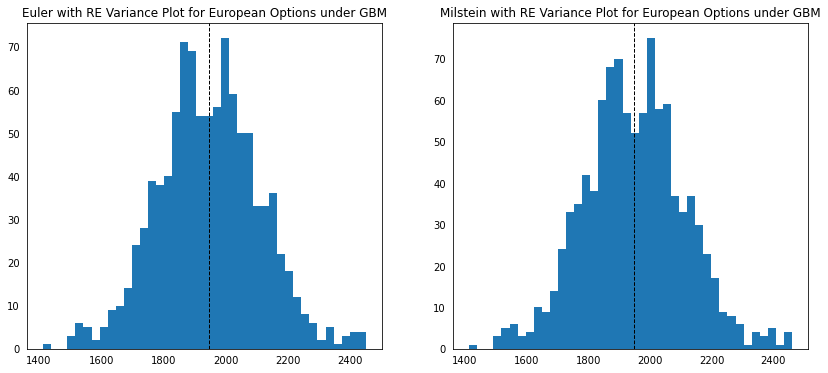

In [210]:
def average(l):
    return sum(l) / len(l)

fig = plt.figure(figsize=(14, 6))

print("Average Euler Variance =", euro_euler_richardson_data[-1])
print("Average Milstein Variance =", euro_milstein_richardson_data[-1])

plt.subplot(1, 2, 1)
plt.title("Euler with RE Variance Plot for European Options under GBM")
plt.hist(euro_euler_richardson_data, bins = 40)
plt.axvline(euro_euler_richardson_data[-1], color='k', linestyle='dashed', linewidth=1)

plt.subplot(1, 2, 2)
plt.title("Milstein with RE Variance Plot for European Options under GBM")
plt.hist(euro_milstein_richardson_data, bins = 40)
plt.axvline(euro_milstein_richardson_data[-1], color='k', linestyle='dashed', linewidth=1)
plt.show()


In [216]:
euler = euro_euler_richardson_data[:-1]
milstein = euro_milstein_richardson_data[:-1]

euler_mean = np.mean(euler)
euler_std = np.std(euler)
print(f"Euler: mean = {euler_mean}, sd = {euler_std}")

milstein_mean = np.mean(milstein)
milstein_std = np.std(milstein)
print(f"Milstein: mean = {milstein_mean}, sd = {milstein_std}")

ttest,pval = ttest_ind(euler, milstein)
print("p-value", pval)

if pval < 0.05:
    print("We reject null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

Euler: mean = 1947.298, sd = 162.77604613701612
Milstein: mean = 1948.791, sd = 162.99325544021752
p-value 0.8377060123165413
We fail to reject the null hypothesis.


### Euler Schme (Asian Options)

In [221]:
def asian_euler_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    
    ## Simulate with time step h
    f1 = []
    t1 = []
    
    # simulate n paths 
    for j in range(n):
        t1 = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*h + sigma*x*math.sqrt(h)*z # price of asset 
            price.append(x) 
            t1 = t1 + h 
        
        avg = average(price)
        if optiontype == "call":
            f1 += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f1 += [put_option_price(avg, r, T, K)]
    
    theta1 = np.sum(f1)/n
    var1 = np.sum((f1 - theta1)**2)/(n-1)
    
    ## Simulate with time step 2h 
    f2 = []
    t2 = []
    
    # simulate n paths 
    for j in range(n):
        t2 = 0 
        x = x0 
        m = int(math.floor(T/(2*h)))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x + r*x*(2*h) + sigma*x*math.sqrt(2*h)*z # price of asset 
            price.append(x)
            t2 = t2 + 2*h 
        
        avg = average(price)
        if optiontype == "call":
            f2 += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f2 += [put_option_price(avg, r, T, K)]
        
    theta2 = np.sum(f2)/n
    var2 = np.sum((f2 - theta2)**2)/(n-1)
    
    ## compiled variables 
    theta = 2*theta1 - theta2
    cov = sum((a - theta1) * (b - theta2) for (a,b) in zip(f1,f2)) / len(f1)
    print("cov =", cov)
    variance = 4*var1 + var2 - 4*cov
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI

In [225]:
print("Euler scheme with Richardson Extrapolation")
asian_euler_richardson(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")

Euler scheme with Richardson Extrapolation
cov = [3.76562814]


(array([7.0215842]), array([602.70779045]), (5, 8))

### Milstein Scheme (Asian Options)

In [226]:
def asian_milstein_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    
    ## Simulate with time step h
    f1 = []
    t1 = []
    
    # simulate n paths 
    for j in range(n):
        t1 = 0 
        x = x0 
        m = int(math.floor(T/h))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x = x + r*x*h + sigma*x*math.sqrt(h)*z + 0.5*sigma*sigma*x*h*(z**2 - 1)
            price.append(x)
            t1 = t1 + h 
        
        avg = average(price)
        if optiontype == "call":
            f1 += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f1 += [put_option_price(avg, r, T, K)] 
        
    theta1 = np.sum(f1)/n
    var1 = np.sum((f1 - theta1)**2)/(n-1)
    
    ## Simulate with time step 2h 
    f2 = []
    t2 = []
    
    # simulate n paths 
    for j in range(n):
        t2 = 0 
        x = x0 
        m = int(math.floor(T/(2*h)))
        
        price = []
        # simulate one path for m number of time steps 
        for k in range(m):
            z = np.random.normal(0, 1, 1)
            x = x = x + r*x*(2*h) + sigma*x*math.sqrt(2*h)*z + 0.5*sigma*sigma*x*(2*h)*(z**2 - 1)
            price.append(x)
            t2 = t2 + 2*h 
        
        avg = average(price)
        if optiontype == "call":
            f2 += [call_option_price(avg, r, T, K)] # price of options
        elif optiontype == "put":
            f2 += [put_option_price(avg, r, T, K)]
        
    theta2 = np.sum(f2)/n
    var2 = np.sum((f2 - theta2)**2)/(n-1)
    
    ## compiled variables 
    theta = 2*theta1 - theta2
    #Michael
#     print(f1)
    variance = np.sum(((2*a - b - theta)**2)/(n-1) for (a, b) in zip(f1, f2))
    cov = sum((a - theta1) * (b - theta2) for (a, b) in zip(f1, f2)) / len(f1)
    print("cov =", cov)
#     variance = 4*var1 + var2 - 4*cov
    left = theta + stats.norm.ppf(alpha/2)*math.sqrt(variance)/math.sqrt(n)
    right = theta + stats.norm.ppf(1 - alpha/2)*math.sqrt(variance)/math.sqrt(n)
    CI = (int(left), int(right))
    
    return theta, variance, CI

# why is my variance so huge?

In [227]:
print("Milstein scheme with Richardson Extrapolation")
asian_milstein_richardson(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")

Milstein scheme with Richardson Extrapolation
cov = [5.16143627]


(array([6.15059603]), array([537.39323439]), (4, 7))

### Average Variance

In [249]:
# Implementation of 1000 runs of Euler scheme
np.random.seed(1)
def asian_euler_richardson1000(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    variance = []
    for i in range(1000):
        variance.append(int(asian_euler_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call")[1]))
    expected_variance = sum(variance)/1000
    variance.append(expected_variance)
    return variance

asian_euler_richardson_data = asian_euler_richardson1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")
print(asian_euler_richardson_data)

<ipython-input-245-d99341252869>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var1 = np.sum((f1 - theta1)**2)/(n-1)
<ipython-input-245-d99341252869>:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var2 = np.sum((f2 - theta2)**2)/(n-1)


[616, 500, 593, 682, 562, 495, 591, 619, 529, 588, 619, 601, 606, 497, 600, 633, 571, 647, 622, 635, 619, 561, 660, 651, 633, 591, 557, 616, 531, 576, 547, 645, 570, 519, 538, 556, 619, 547, 626, 644, 595, 555, 511, 690, 590, 581, 567, 620, 532, 489, 568, 532, 640, 592, 667, 598, 594, 482, 638, 626, 599, 577, 567, 534, 522, 634, 562, 591, 599, 515, 571, 594, 546, 608, 612, 626, 572, 565, 594, 590, 614, 530, 633, 599, 637, 549, 619, 551, 591, 630, 534, 573, 537, 533, 593, 602, 534, 536, 569, 507, 606, 618, 534, 585, 557, 499, 609, 608, 532, 614, 661, 580, 580, 563, 561, 612, 502, 614, 594, 524, 561, 521, 582, 553, 548, 634, 534, 606, 604, 534, 594, 628, 544, 536, 605, 683, 520, 503, 529, 597, 586, 563, 599, 603, 657, 551, 510, 539, 602, 534, 595, 593, 566, 600, 545, 603, 554, 537, 578, 541, 661, 535, 572, 567, 588, 512, 620, 492, 584, 665, 583, 615, 688, 622, 565, 549, 609, 569, 631, 580, 613, 636, 527, 554, 610, 548, 627, 542, 593, 570, 547, 568, 616, 570, 468, 578, 624, 574, 610, 616,

In [251]:
# Save results to excel 
book = xlwt.Workbook()
sheet1 = book.add_sheet('sheet1')

for i,e in enumerate(euro_euler_richardson_data):
    sheet1.write(i,1,e)

name = "euro_euler_richardson_data.xls"
book.save(name)
book.save(TemporaryFile())

In [253]:
# Implementation of 1000 runs of Euler scheme
np.random.seed(1)
def asian_milstein_richardson1000(x0, r, T, K, h, n, sigma, alpha, optiontype = "call"):
    variance = []
    for i in range(1000):
        variance.append(int(asian_milstein_richardson(x0, r, T, K, h, n, sigma, alpha, optiontype = "call")[1]))
    expected_variance = sum(variance)/1000
    variance.append(expected_variance)
    return variance

asian_milstein_richardson_data = asian_milstein_richardson1000(100, 0.01, 0.5, 100, 0.001, 1000, 0.4, 0.05, optiontype = "call")
print(asian_milstein_richardson_data)

<ipython-input-243-3c6fd7d5ccf4>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var1 = np.sum((f1 - theta1)**2)/(n-1)
<ipython-input-243-3c6fd7d5ccf4>:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var2 = np.sum((f2 - theta2)**2)/(n-1)
<ipython-input-243-3c6fd7d5ccf4>:61: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  variance = np.sum(((2*a - b - theta)**2)/(n-1) for (a, b) in zip(f1, f2))


[617, 500, 595, 683, 563, 496, 592, 620, 530, 589, 620, 602, 605, 498, 601, 634, 572, 648, 624, 637, 617, 562, 660, 652, 633, 592, 558, 617, 532, 577, 548, 646, 570, 519, 539, 556, 620, 549, 628, 645, 595, 556, 512, 691, 591, 582, 568, 619, 532, 490, 569, 533, 640, 593, 668, 598, 596, 483, 638, 627, 599, 577, 568, 535, 522, 636, 563, 591, 601, 515, 573, 595, 547, 608, 614, 627, 572, 566, 594, 589, 614, 530, 634, 599, 638, 549, 619, 551, 592, 630, 534, 573, 538, 534, 593, 603, 535, 537, 570, 508, 607, 618, 535, 586, 558, 499, 609, 609, 532, 615, 662, 581, 580, 564, 561, 612, 504, 615, 595, 524, 561, 521, 583, 554, 548, 635, 535, 606, 605, 535, 595, 629, 544, 537, 605, 683, 521, 505, 529, 599, 586, 563, 600, 604, 658, 552, 509, 539, 602, 533, 595, 593, 565, 602, 546, 603, 555, 537, 578, 541, 663, 535, 573, 568, 588, 513, 620, 493, 584, 666, 584, 615, 688, 623, 565, 550, 610, 570, 632, 581, 615, 637, 526, 554, 611, 548, 627, 542, 593, 570, 547, 568, 616, 571, 468, 579, 625, 576, 610, 617,

In [254]:
# Save results to excel 
book = xlwt.Workbook()
sheet2 = book.add_sheet('sheet2')

for i,e in enumerate(asian_milstein_richardson_data):
    sheet2.write(i, 1, e)

name = "asian_milstein_richardson_data.xls"
book.save(name)
book.save(TemporaryFile())

In [5]:
asian_euler_richardson_data = [616, 500, 593, 682, 562, 495, 591, 619, 529, 588, 619, 601, 606, 497, 600, 633, 571, 647, 622, 635, 619, 561, 660, 651, 633, 591, 557, 616, 531, 576, 547, 645, 570, 519, 538, 556, 619, 547, 626, 644, 595, 555, 511, 690, 590, 581, 567, 620, 532, 489, 568, 532, 640, 592, 667, 598, 594, 482, 638, 626, 599, 577, 567, 534, 522, 634, 562, 591, 599, 515, 571, 594, 546, 608, 612, 626, 572, 565, 594, 590, 614, 530, 633, 599, 637, 549, 619, 551, 591, 630, 534, 573, 537, 533, 593, 602, 534, 536, 569, 507, 606, 618, 534, 585, 557, 499, 609, 608, 532, 614, 661, 580, 580, 563, 561, 612, 502, 614, 594, 524, 561, 521, 582, 553, 548, 634, 534, 606, 604, 534, 594, 628, 544, 536, 605, 683, 520, 503, 529, 597, 586, 563, 599, 603, 657, 551, 510, 539, 602, 534, 595, 593, 566, 600, 545, 603, 554, 537, 578, 541, 661, 535, 572, 567, 588, 512, 620, 492, 584, 665, 583, 615, 688, 622, 565, 549, 609, 569, 631, 580, 613, 636, 527, 554, 610, 548, 627, 542, 593, 570, 547, 568, 616, 570, 468, 578, 624, 574, 610, 616, 606, 628, 590, 602, 507, 529, 609, 542, 648, 610, 609, 571, 511, 607, 577, 711, 586, 538, 592, 566, 558, 641, 591, 584, 597, 574, 595, 635, 607, 563, 579, 641, 597, 537, 635, 593, 577, 540, 560, 583, 538, 507, 570, 564, 516, 567, 535, 588, 611, 585, 586, 642, 587, 571, 538, 599, 615, 584, 673, 554, 582, 588, 517, 624, 555, 532, 683, 575, 558, 601, 681, 656, 594, 615, 558, 589, 737, 591, 577, 633, 554, 554, 665, 628, 561, 595, 604, 608, 565, 634, 550, 590, 548, 641, 573, 657, 597, 607, 565, 643, 581, 609, 591, 593, 603, 570, 559, 607, 583, 552, 589, 583, 567, 537, 564, 596, 516, 578, 615, 540, 608, 590, 559, 648, 502, 558, 521, 534, 560, 595, 540, 646, 613, 570, 558, 574, 600, 559, 591, 661, 512, 568, 577, 634, 612, 539, 589, 510, 545, 647, 586, 621, 532, 644, 597, 591, 519, 538, 569, 628, 709, 593, 542, 627, 572, 673, 570, 614, 547, 530, 589, 571, 557, 641, 551, 608, 577, 528, 553, 608, 463, 616, 502, 596, 598, 669, 657, 556, 663, 580, 539, 518, 628, 528, 725, 662, 582, 548, 598, 517, 635, 448, 637, 535, 622, 523, 549, 549, 507, 600, 586, 619, 553, 519, 581, 521, 598, 556, 561, 635, 569, 539, 620, 568, 558, 624, 641, 573, 552, 652, 542, 641, 733, 593, 574, 545, 581, 623, 598, 617, 556, 586, 619, 560, 558, 596, 674, 605, 549, 573, 580, 650, 634, 642, 563, 545, 553, 617, 570, 566, 593, 667, 611, 586, 499, 642, 552, 606, 525, 534, 631, 607, 621, 584, 579, 578, 673, 661, 563, 554, 577, 480, 548, 559, 613, 560, 508, 529, 547, 602, 566, 574, 592, 636, 567, 548, 648, 577, 539, 575, 577, 598, 530, 655, 529, 545, 578, 595, 581, 600, 620, 646, 604, 499, 601, 614, 548, 514, 515, 591, 540, 559, 576, 660, 524, 590, 602, 622, 568, 565, 567, 502, 632, 596, 578, 601, 589, 579, 510, 619, 552, 562, 563, 630, 572, 572, 642, 643, 512, 549, 593, 611, 652, 583, 582, 577, 592, 602, 533, 587, 663, 552, 619, 544, 649, 545, 561, 673, 556, 594, 603, 615, 560, 548, 637, 624, 666, 593, 597, 613, 548, 507, 561, 534, 630, 628, 601, 570, 601, 584, 667, 602, 648, 672, 616, 635, 685, 589, 658, 523, 671, 587, 527, 616, 677, 561, 611, 601, 630, 574, 492, 573, 695, 492, 530, 521, 660, 587, 574, 565, 529, 583, 530, 584, 615, 528, 599, 561, 519, 617, 531, 642, 588, 627, 540, 570, 599, 522, 558, 571, 573, 596, 594, 555, 608, 635, 560, 606, 590, 575, 537, 523, 603, 510, 574, 536, 548, 654, 587, 523, 574, 578, 565, 578, 603, 598, 539, 669, 587, 586, 645, 550, 531, 628, 532, 558, 588, 583, 597, 656, 609, 563, 537, 537, 489, 456, 563, 555, 602, 609, 557, 608, 556, 588, 607, 580, 573, 603, 628, 594, 540, 593, 550, 568, 603, 563, 577, 564, 630, 644, 556, 621, 624, 562, 582, 633, 588, 594, 642, 630, 664, 569, 597, 664, 575, 568, 622, 608, 610, 551, 623, 573, 664, 626, 568, 528, 619, 580, 523, 596, 629, 567, 550, 557, 632, 586, 514, 620, 560, 550, 594, 560, 613, 539, 613, 570, 559, 606, 563, 633, 627, 528, 589, 613, 668, 535, 669, 698, 621, 579, 532, 578, 574, 530, 550, 639, 671, 711, 531, 649, 585, 602, 500, 674, 582, 587, 665, 603, 631, 588, 539, 677, 568, 602, 610, 585, 577, 603, 690, 640, 590, 554, 511, 551, 594, 619, 597, 592, 518, 541, 529, 629, 538, 521, 633, 616, 544, 554, 559, 603, 551, 611, 508, 618, 663, 612, 582, 505, 634, 534, 535, 616, 601, 508, 556, 549, 594, 577, 655, 641, 554, 651, 517, 625, 585, 623, 543, 528, 589, 576, 553, 576, 667, 554, 478, 609, 560, 631, 557, 557, 566, 546, 646, 573, 603, 524, 548, 589, 615, 580, 521, 645, 480, 550, 630, 578, 546, 633, 603, 574, 610, 656, 624, 659, 588, 592, 602, 554, 582, 567, 552, 578, 595, 554, 644, 666, 667, 592, 477, 602, 562, 600, 580, 669, 612, 629, 598, 538, 584, 587, 570, 608, 535, 487, 609, 526, 565, 611, 555, 569, 627, 611, 623, 580, 580, 627, 615, 595, 552, 569, 625, 542, 549, 545, 546, 578, 553, 644, 574, 587, 624, 602, 558, 599, 564, 534, 639, 570, 637, 571, 606, 627, 434, 559, 541, 646, 707, 609, 637, 711, 602, 570, 567, 564, 571, 596, 512, 605, 585, 579, 590, 617, 618, 540, 617, 538, 516, 609, 609, 604, 626, 571, 496, 644, 547, 524, 648, 612, 603, 577, 562, 660, 576, 612, 534, 623, 570, 570, 533, 630, 584.673]
asian_milstein_richardson_data = [617, 500, 595, 683, 563, 496, 592, 620, 530, 589, 620, 602, 605, 498, 601, 634, 572, 648, 624, 637, 617, 562, 660, 652, 633, 592, 558, 617, 532, 577, 548, 646, 570, 519, 539, 556, 620, 549, 628, 645, 595, 556, 512, 691, 591, 582, 568, 619, 532, 490, 569, 533, 640, 593, 668, 598, 596, 483, 638, 627, 599, 577, 568, 535, 522, 636, 563, 591, 601, 515, 573, 595, 547, 608, 614, 627, 572, 566, 594, 589, 614, 530, 634, 599, 638, 549, 619, 551, 592, 630, 534, 573, 538, 534, 593, 603, 535, 537, 570, 508, 607, 618, 535, 586, 558, 499, 609, 609, 532, 615, 662, 581, 580, 564, 561, 612, 504, 615, 595, 524, 561, 521, 583, 554, 548, 635, 535, 606, 605, 535, 595, 629, 544, 537, 605, 683, 521, 505, 529, 599, 586, 563, 600, 604, 658, 552, 509, 539, 602, 533, 595, 593, 565, 602, 546, 603, 555, 537, 578, 541, 663, 535, 573, 568, 588, 513, 620, 493, 584, 666, 584, 615, 688, 623, 565, 550, 610, 570, 632, 581, 615, 637, 526, 554, 611, 548, 627, 542, 593, 570, 547, 568, 616, 571, 468, 579, 625, 576, 610, 617, 607, 628, 591, 603, 508, 531, 609, 544, 649, 611, 611, 571, 512, 608, 578, 711, 586, 538, 594, 567, 557, 642, 591, 585, 598, 574, 595, 635, 607, 564, 580, 642, 596, 538, 636, 593, 578, 540, 561, 583, 539, 508, 571, 565, 517, 568, 535, 589, 611, 585, 586, 642, 588, 571, 538, 598, 615, 584, 673, 554, 583, 588, 517, 625, 555, 531, 684, 576, 558, 601, 682, 656, 594, 616, 559, 590, 738, 591, 578, 634, 554, 554, 666, 629, 562, 595, 606, 608, 565, 635, 551, 590, 548, 640, 572, 658, 597, 606, 565, 643, 580, 611, 591, 594, 603, 571, 559, 607, 583, 553, 589, 583, 567, 536, 564, 597, 518, 579, 614, 541, 608, 590, 559, 648, 503, 558, 521, 535, 561, 595, 539, 645, 614, 570, 558, 574, 600, 559, 591, 662, 513, 569, 578, 634, 613, 540, 590, 510, 546, 648, 585, 622, 532, 645, 597, 591, 520, 539, 569, 628, 709, 594, 542, 627, 572, 673, 571, 615, 546, 530, 590, 571, 557, 642, 552, 610, 577, 528, 554, 608, 464, 617, 504, 596, 599, 670, 658, 555, 663, 580, 540, 518, 628, 530, 726, 663, 582, 549, 598, 518, 636, 449, 638, 535, 623, 524, 550, 550, 508, 601, 587, 620, 555, 520, 582, 521, 598, 556, 561, 635, 570, 539, 622, 568, 558, 624, 641, 574, 552, 652, 544, 641, 734, 593, 575, 546, 581, 623, 600, 619, 556, 586, 620, 561, 560, 596, 675, 606, 551, 574, 581, 651, 634, 642, 563, 546, 555, 618, 570, 566, 594, 668, 613, 587, 499, 641, 553, 607, 526, 535, 633, 608, 621, 584, 580, 579, 675, 662, 563, 554, 578, 481, 549, 559, 614, 561, 509, 530, 548, 603, 567, 575, 593, 636, 568, 548, 648, 577, 539, 577, 577, 598, 530, 657, 529, 545, 578, 596, 581, 600, 621, 646, 604, 500, 603, 614, 549, 515, 516, 592, 542, 560, 577, 660, 524, 590, 603, 622, 568, 567, 568, 503, 634, 595, 579, 601, 589, 579, 511, 620, 553, 563, 565, 630, 573, 572, 642, 644, 512, 549, 594, 612, 653, 583, 582, 579, 594, 602, 534, 588, 666, 552, 619, 544, 651, 545, 562, 674, 557, 595, 604, 615, 561, 548, 638, 625, 666, 593, 599, 613, 548, 507, 562, 535, 630, 629, 601, 571, 602, 584, 667, 602, 649, 671, 617, 636, 685, 589, 659, 524, 671, 587, 527, 616, 677, 562, 612, 602, 631, 574, 491, 574, 696, 492, 529, 522, 661, 588, 575, 565, 529, 584, 531, 585, 615, 528, 599, 562, 519, 616, 532, 642, 589, 627, 540, 571, 599, 522, 558, 572, 574, 598, 595, 555, 609, 635, 561, 607, 591, 576, 539, 524, 604, 511, 574, 537, 548, 655, 588, 522, 576, 579, 566, 579, 604, 598, 539, 670, 588, 585, 646, 551, 531, 630, 532, 559, 589, 583, 597, 657, 610, 563, 539, 538, 489, 456, 562, 555, 603, 609, 557, 608, 556, 589, 608, 581, 574, 605, 630, 594, 541, 593, 550, 567, 602, 564, 577, 564, 631, 647, 557, 622, 624, 562, 583, 635, 589, 595, 642, 632, 664, 570, 598, 664, 575, 567, 622, 606, 610, 552, 624, 574, 666, 627, 568, 528, 619, 581, 523, 596, 629, 567, 550, 557, 633, 587, 515, 620, 561, 550, 595, 561, 614, 540, 614, 571, 559, 606, 563, 634, 627, 528, 590, 614, 668, 535, 669, 699, 622, 580, 532, 579, 575, 531, 551, 640, 672, 712, 533, 650, 584, 603, 501, 675, 581, 587, 667, 604, 631, 589, 540, 678, 569, 602, 611, 584, 578, 603, 691, 641, 591, 555, 511, 552, 593, 619, 597, 593, 519, 541, 529, 630, 539, 522, 634, 616, 546, 554, 559, 603, 551, 613, 508, 619, 664, 614, 583, 507, 635, 535, 536, 617, 602, 508, 556, 549, 594, 577, 656, 641, 555, 651, 517, 625, 585, 624, 543, 528, 589, 575, 554, 576, 668, 555, 477, 610, 560, 632, 557, 558, 567, 546, 647, 572, 605, 523, 548, 590, 616, 580, 521, 645, 481, 551, 630, 578, 548, 634, 605, 575, 611, 658, 625, 659, 588, 592, 604, 554, 583, 568, 553, 580, 595, 554, 643, 667, 667, 592, 478, 602, 563, 601, 580, 670, 612, 629, 598, 538, 584, 588, 571, 609, 535, 486, 610, 527, 565, 612, 557, 570, 628, 612, 624, 582, 580, 627, 615, 597, 553, 570, 625, 542, 550, 545, 546, 579, 554, 646, 574, 586, 625, 602, 559, 599, 564, 536, 639, 570, 638, 571, 606, 627, 435, 559, 541, 647, 709, 610, 638, 712, 603, 570, 568, 564, 573, 596, 513, 607, 585, 581, 590, 617, 619, 540, 618, 540, 517, 608, 610, 605, 626, 573, 497, 645, 548, 523, 649, 613, 603, 578, 562, 661, 576, 612, 535, 623, 570, 571, 535, 631, 585.259]

In [228]:
# # Converting our saved results to a list 

# euler = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/asian_euler_richardson_data.xls")
# euro_euler_richardson_data = euler["Variance Value"].to_list()

# milstein = pd.read_excel("/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/asian_milstein_richardson_data.xls")
# euro_milstein_richardson_data = milstein["Variance Value"].to_list()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yilin/Desktop/Yale-NUS/Y4S2/Capstone/Semester 2/asian_euler_richardson_data.xls'

Average Euler Variance = 584.673
Average Milstein Variance = 585.259


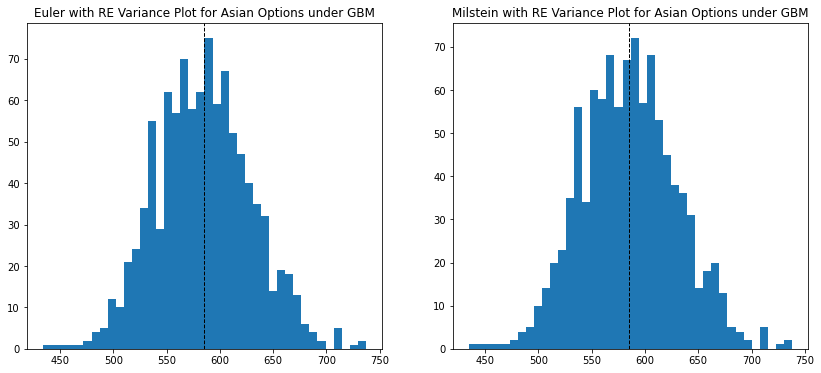

In [6]:
def average(l):
    return sum(l) / len(l)

fig = plt.figure(figsize=(14, 6))

print("Average Euler Variance =", asian_euler_richardson_data[-1])
print("Average Milstein Variance =", asian_milstein_richardson_data[-1])

plt.subplot(1, 2, 1)
plt.title("Euler with RE Variance Plot for Asian Options under GBM")
plt.hist(asian_euler_richardson_data, bins = 40)
plt.axvline(asian_milstein_richardson_data[-1], color='k', linestyle='dashed', linewidth=1)

plt.subplot(1, 2, 2)
plt.title("Milstein with RE Variance Plot for Asian Options under GBM")
plt.hist(asian_milstein_richardson_data, bins = 40)
plt.axvline(asian_milstein_richardson_data[-1], color='k', linestyle='dashed', linewidth=1)
plt.show()


In [9]:
euler = asian_euler_richardson_data[:-1]
milstein = asian_milstein_richardson_data[:-1]

euler_mean = np.mean(euler)
euler_std = np.std(euler)
print(f"Euler: mean = {euler_mean}, sd = {euler_std}")

milstein_mean = np.mean(milstein)
milstein_std = np.std(milstein)
print(f"Milstein: mean = {milstein_mean}, sd = {milstein_std}")

ttest,pval = ttest_ind(euler, milstein)
print("p-value", pval)

if pval < 0.05:
    print("We reject null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

Euler: mean = 584.673, sd = 44.74105576537058
Milstein: mean = 585.259, sd = 44.79812405670577
p-value 0.7699057520519126
We fail to reject the null hypothesis.


Next steps:
* Put-option prices: use put-call parity or if elif statements 
* Try implementing BM for American option 

Next steps: 
* read the readings that prof send 
* restructure the entire project (est drift and volatility) 